# Final Homework - Statistical Learning



### Professor:

- Pierpaolo Brutti

### Student:

- Name: Arman
- Surname: Feili
- Matricola: 2101835
- Email: feili.2101835@studenti.uniroma1.it

## June and July Enhancements

### Solve Python Packages Inconsistency

* We make sure the right versions of numpy, scipy, and scikit-learn are installed for compatibility.
* Our session restarts to apply any package changes and avoid import errors.
* Then, there’s some patching of numpy internals to avoid issues with records and string handling (Because sometimes Colab or other environments have missing modules).


In [ ]:
# Ensure compatible core dependencies before any import
%pip install -q numpy==1.26.4 scipy==1.11.4 scikit-learn==1.3.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 50.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.8 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os; os.kill(os.getpid(), 9)


In [ ]:
import sys, importlib, types
try:
    recmod = importlib.import_module("numpy.core.records")
except ImportError:
    recmod = types.ModuleType("numpy.rec")
sys.modules["numpy.rec"] = recmod
try:
    strmod = importlib.import_module("numpy._core.defchararray")
except ImportError:
    strmod = types.ModuleType("numpy.strings")
sys.modules["numpy.strings"] = strmod
import numpy as _np
_np.rec = recmod
_np.strings = strmod


### Environment Setup

The Process:

* We import key libraries: numpy, pandas, matplotlib, plus machine learning tools from sklearn and keras.
* Random seeds are set so our results stay consistent each run.
* Google Drive is mounted for file access, and we set the working directory.
* The linear-diffusion repo is cloned from GitHub (if needed) and the code moves into that folder.
* Configs are defined: how much MNIST data to use, latent sizes, noise levels, number of images, diffusion steps, and kernel params.
* We stick with logistic regression as our only classifier, since SVM and Random Forest didn’t work as well in earlier tests.


Variable Explanations:

* `USE_FULL_MNIST`: Whether we use the entire MNIST dataset or a smaller subset for memory reasons
* `N_TRAIN`: Number of training images selected, depends on `USE_FULL_MNIST`
* `N_TEST`: Number of test images selected, depends on `USE_FULL_MNIST`
* `LATENT_SIZES`: List of latent space dimensions we’ll sweep over in our experiments
* `STD_VALUES`: List of noise standard deviations to test
* `N_PER_DIGIT`: Number of images to generate per digit in a balanced sample
* `DIFFUSION_STEPS_LIST`: List of T values, the diffusion steps to sweep
* `RBF_GAMMAS`: List of gamma values to try for the RBF kernel in KernelPCA
* `KERNELS`: List of kernel configs (RBF, poly, sigmoid) and their hyperparameters for KernelPCA
* `USE_LOGISTIC`: If True, we’ll use logistic regression as our main classifier
* `USE_SVM`: If True, we’ll also try SVM classifier
* `USE_RF`: If True, we’ll also try Random Forest classifier
* `SEED`: The random seed for reproducibility
* `target_dir`: The working directory in Google Drive for all our project files


In [ ]:
# IMPORTS

import os
import random
import numpy as np
import pandas as pd
import gc
import time
from IPython.display import display

from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import KernelPCA, PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.calibration import CalibratedClassifierCV

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# GOOGLE DRIVE & WORKDIR

from google.colab import drive
drive.mount('/content/gdrive')

target_dir = '/content/gdrive/MyDrive/Sapienza-Work-Place/SL_G21/Homework-1'
os.chdir(target_dir)
print("Working in:", os.getcwd())

# PROJECT SETUP (CLONE REPO ONLY)

if not os.path.isdir('linear-diffusion'):
    !git clone https://github.com/willkurt/linear-diffusion.git
%cd linear-diffusion

from lineardiffusion import LinearDiffusion

# CONFIGURATION & EXPERIMENTAL PARAMETERS

USE_FULL_MNIST = False  # We set it to False for small RAM (12 GB) of Colab, to avoid memory hit
N_TRAIN = 60000 if USE_FULL_MNIST else 8000
N_TEST = 10000 if USE_FULL_MNIST else 2000

LATENT_SIZES = [8, 10, 12]
STD_VALUES = [1.0, 1.5, 2.0]
N_PER_DIGIT = 50

# DIFFUSION STEPS (T) values to sweep
DIFFUSION_STEPS_LIST = [400, 1000]

# RBF kernel gamma sweep (fine grid)
RBF_GAMMAS = [0.002, 0.003, 0.005]

# Kernels to test, with their specific param sweeps
KERNELS = [
    {'name': 'rbf', 'gamma': RBF_GAMMAS},  # RBF Kernel (Radial Basis Function, "Gaussian")
    {'name': 'poly', 'degree': [2, 3], 'coef0': [0, 1]}, # Polynomial Kernel
    {'name': 'sigmoid', 'coef0': [0, 1]}, # ("neural net kernel")
]

# There are 180 permutations based on above configs

# We only set LOGISTIC classifier to True, because we observed poor performance on SVM and RF classifiers
USE_LOGISTIC = True
USE_SVM = False
USE_RF = False

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Working in: /content/gdrive/MyDrive/Sapienza-Work-Place/SL_G21/Homework-1
/content/gdrive/MyDrive/Sapienza-Work-Place/SL_G21/Homework-1/linear-diffusion


### Data Loading & Splitting

The Process:

* We load the MNIST dataset and pick the number of samples we want for training and testing.
* Images and labels are merged so we can split them evenly into training, calibration, and test sets, using stratified sampling to keep the digit distribution balanced.
* Images are flattened to fit standard ML models, and we create a balanced test label set so every digit is equally represented.
* We set up our classifiers (logistic regression, SVM, random forest) with scaling and PCA, but we mostly use logistic regression based on our config.
* Logistic regression is trained on the training data; SVM and random forest are ready but only used if enabled.


Variable Explanations:

* `train_imgs, train_labels`: original training images and labels from MNIST
* `test_imgs, test_labels`: original test images and labels from MNIST
* `all_imgs`: concatenation of selected train and test images
* `all_labels`: concatenation of selected train and test labels
* `indices`: array of indices for all images, used for splitting
* `train_idx, temp_idx`: indices for training set and temporary set (calib+test) after first split
* `calib_idx, test_idx`: indices for calibration and test sets after second split
* `imgs_train, imgs_calib, imgs_test`: split images for training, calibration, and test
* `labels_train, labels_calib, labels_test`: split labels for training, calibration, and test
* `flat_imgs_train, flat_imgs_calib, flat_imgs_test`: flattened image arrays for each set
* `balanced_sample`: function to generate a balanced set of labels (same count per class)
* `balanced_labels_test`: a balanced set of labels for generating or evaluating test samples
* `clf_log`: logistic regression classifier pipeline
* `clf_svm`: SVM classifier pipeline
* `clf_rf`: random forest classifier pipeline
* `USE_LOGISTIC, USE_SVM, USE_RF`: flags that decide which classifiers we actually use


In [ ]:
# DATA LOADING & TRUE GENERALIZATION SPLIT

from sklearn.model_selection import train_test_split

(train_imgs, train_labels), (test_imgs, test_labels) = mnist.load_data()
all_imgs = np.concatenate([train_imgs[:N_TRAIN], test_imgs[:N_TEST]])
all_labels = np.concatenate([train_labels[:N_TRAIN], test_labels[:N_TEST]])
assert all_imgs.shape[0] == all_labels.shape[0]

# Split: 80% train, 10% calib, 10% test (stratified)
indices = np.arange(all_imgs.shape[0])

# First split: train vs (calib+test)
train_idx, temp_idx = train_test_split(
    indices, test_size=0.2, random_state=SEED, stratify=all_labels
)
# Second split: calib vs test (from temp)
calib_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=SEED, stratify=all_labels[temp_idx]
)

imgs_train, imgs_calib, imgs_test = all_imgs[train_idx], all_imgs[calib_idx], all_imgs[test_idx]
labels_train, labels_calib, labels_test = all_labels[train_idx], all_labels[calib_idx], all_labels[test_idx]

flat_imgs_train = imgs_train.reshape(len(imgs_train), -1)
flat_imgs_calib = imgs_calib.reshape(len(imgs_calib), -1)
flat_imgs_test  = imgs_test.reshape(len(imgs_test), -1)

# Create a balanced test set for generation (e.g. 50 per class)
def balanced_sample(labels, n_per_digit=50):
    result = []
    for d in range(10):  # Ensure you sample all digits
        idx = np.where(labels == d)[0]
        idx = np.random.choice(idx, n_per_digit, replace=False)
        result.extend([d]*n_per_digit)
    return np.array(result)

balanced_labels_test = balanced_sample(labels_test, N_PER_DIGIT)

unique, counts = np.unique(balanced_labels_test, return_counts=True)
print(f"Balanced test set contains {dict(zip(unique, counts))}")

clf_log = clf_svm = clf_rf = None

if USE_LOGISTIC:
    clf_log = make_pipeline(
        StandardScaler(),
        PCA(n_components=50, svd_solver="randomized", random_state=SEED),
        LogisticRegression(
            solver="saga",
            max_iter=1000,
            n_jobs=-1,
            multi_class="multinomial",
            random_state=SEED)
    )
    clf_log.fit(flat_imgs_train, labels_train)
    print("LogisticRegression classifier trained.")

if USE_SVM:
    clf_svm = make_pipeline(
        StandardScaler(),
        PCA(n_components=50, svd_solver="randomized", random_state=SEED),
        SVC(kernel="rbf", C=1, gamma="scale", random_state=SEED, probability=True)
    )
    clf_svm.fit(flat_imgs_train, labels_train)
    print("SVM classifier trained.")

if USE_RF:
    clf_rf = make_pipeline(
        StandardScaler(),
        PCA(n_components=50, svd_solver="randomized", random_state=SEED),
        RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=SEED)
    )
    clf_rf.fit(flat_imgs_train, labels_train)
    print("RandomForest classifier trained.")

Balanced test set contains {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50}
LogisticRegression classifier trained.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The Process:

* We create a `LinearDiffusionNonlinear` class to support nonlinear encoders like KernelPCA (RBF, polynomial, sigmoid) with customizable settings.
* The model generates richer features by combining label embeddings and noise, capturing complex patterns in latent space.
* Fitting the model means encoding images/labels, building the encoder, generating features, and learning a mapping with Ridge regression.
* Predictions can use fixed or time-varying noise, always decoding results back to images through the right transforms.
* The setup allows easy switching between PCA and nonlinear encoders, with optional PCA before KernelPCA for extra compression.
* We optimize state and memory handling for efficient runs, even on big experiments.

Variable and Functions Explanations:

* `LinearDiffusionNonlinear`: the subclass implementing nonlinear encoding (KernelPCA-based) for latent space
* `latent_dim`: number of latent features (latent\_size squared)
* `use_kernel_pca`: flag for whether to use KernelPCA or standard PCA
* `kpca_kernel`: the type of kernel used in KernelPCA (e.g., 'rbf', 'poly', 'sigmoid')
* `kpca_gamma`: gamma parameter for the RBF kernel
* `kpca_degree`: degree for the polynomial kernel
* `kpca_coef0`: coefficient for poly and sigmoid kernels
* `pca_before_kpca`: whether to add a PCA step before KernelPCA for initial dimensionality reduction
* `pca_n_components`: number of principal components to use if PCA before KPCA is enabled
* `text_encoder`: label encoder for turning class labels into one-hot vectors
* `image_encoder`: the actual pipeline (PCA/KernelPCA/scaler) used to transform images into latent space
* `model`: Ridge regression model mapping features to the clean latent vector
* `_fit_image_encoder`: internal flag to control when the image encoder needs to be refit
* `fit`: method that trains the latent regressor and builds the feature pipeline
* `predict`: method that generates images given a list of labels, supporting both deterministic and stochastic noise schedules
* `_create_features_noise`: builds features by combining label one-hots, noise, and their Kronecker interactions with the latent representation
* `_build_image_encoder`: sets up the image encoder pipeline based on configuration
* `apply_cosine_schedule`: generates time-varying noise variances for diffusion-style generation
* `strided_sampling_schedule`: computes which time steps to use for strided sampling during generation


In [ ]:
# SUBCLASS FOR NONLINEAR ENCODER (INTERACTIONS, NOISE→CLEAN LATENT, KPCA inverse)

class LinearDiffusionNonlinear(LinearDiffusion):
    """
    LinearDiffusion + KernelPCA, supports Kronecker label-latent interaction,
    predicts the clean latent (z) from label + noise.
    Uses KPCA's own inverse_transform for image decoding (best generalization).
    LinearDiffusion + KernelPCA.
    - `kpca_gamma`: used for 'rbf' kernel
    - `kpca_degree`, `kpca_coef0`: used for 'poly' (degree, coef0) and 'sigmoid' (coef0)
    """
    def __init__(
        self, image_size=28, latent_size=8,
        use_kernel_pca=True, kpca_kernel='rbf',
        kpca_gamma=None, kpca_degree=3, kpca_coef0=1.0,
        pca_before_kpca=False, pca_n_components=50
    ):
        self.latent_dim = latent_size * latent_size
        self.original_latent_size = latent_size
        super().__init__(image_size, self.latent_dim)
        self.use_kernel_pca = use_kernel_pca
        self.kpca_kernel = kpca_kernel
        self.kpca_gamma = kpca_gamma
        self.kpca_degree = kpca_degree
        self.kpca_coef0 = kpca_coef0
        self.pca_before_kpca = pca_before_kpca
        self.pca_n_components = pca_n_components
        self._fit_image_encoder = False
        self.decoder = None


    def _create_features_noise(self, text_embeddings, image_embeddings=None, std=1.0, seed=42):
        rng = np.random.RandomState(seed)
        n_labels = text_embeddings.shape[1]
        latent_dim = image_embeddings.shape[1] if image_embeddings is not None else self.latent_dim
        noise = rng.normal(0, std, size=(text_embeddings.shape[0], latent_dim)).astype(np.float32)
        noised_latent = image_embeddings + noise if image_embeddings is not None else noise
        interactions = (text_embeddings[:, :, None] * noised_latent[:, None, :]).reshape(text_embeddings.shape[0], -1)
        X = np.concatenate([text_embeddings, noised_latent, interactions], axis=1).astype(np.float32)
        return X, image_embeddings

    def _build_image_encoder(self, flat=None):
        if self.use_kernel_pca:
            steps = [('scaler', StandardScaler())]
            if self.pca_before_kpca:
                steps.append(('pca', PCA(n_components=self.pca_n_components, random_state=SEED)))

            kpca_kwargs = dict(
                n_components=self.latent_dim,
                kernel=self.kpca_kernel,
                fit_inverse_transform=True,
                random_state=SEED
            )

            # Kernel-specific settings
            if self.kpca_kernel == 'rbf' and self.kpca_gamma is not None:
                kpca_kwargs['gamma'] = self.kpca_gamma
            elif self.kpca_kernel == 'poly':
                kpca_kwargs['degree'] = self.kpca_degree
                kpca_kwargs['coef0'] = self.kpca_coef0
            elif self.kpca_kernel == 'sigmoid':
                kpca_kwargs['coef0'] = self.kpca_coef0

            steps.append(('kpca', KernelPCA(**kpca_kwargs)))
            self.image_encoder = Pipeline(steps)
        else:
            self.image_encoder = Pipeline([
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=self.latent_dim, random_state=SEED))
            ])


    def fit(self, X_labels, X_images, T=1000):
        flat = X_images.reshape(len(X_images), -1).astype(np.float32) / 255.0
        self.text_encoder = LabelEncoder()
        labels = np.array(X_labels).reshape(-1)
        self.text_encoder.fit(labels)
        n_classes = len(self.text_encoder.classes_)
        ints = self.text_encoder.transform(labels)
        text_encoded = np.eye(n_classes)[ints]
        text_dim = text_encoded.shape[1]

        if hasattr(self, "_fit_image_encoder") and self._fit_image_encoder:
            self._fit_image_encoder = False
            images_encoded = self.image_encoder.transform(flat)
        else:
            self._build_image_encoder()
            self.image_encoder.fit(flat)
            images_encoded = self.image_encoder.transform(flat)
        X_train, y_target = self._create_features_noise(text_encoded, images_encoded)
        expected_features = text_encoded.shape[1] + self.latent_dim + text_encoded.shape[1]*self.latent_dim
        assert X_train.shape[1] == expected_features, f"X_train.shape={X_train.shape}, expected_features={expected_features}"
        assert y_target.shape[1] == self.latent_dim
        self.model = Ridge(alpha=1.0).fit(X=X_train, y=y_target)
        self.text_dim = text_encoded.shape[1]
        self._fit = True
        del flat, images_encoded, X_train, y_target
        gc.collect()
        return self

    def predict(
        self, X, seed=1337, S=10, T=1000, deterministic=True, std=1.0
    ):
        """
        deterministic=True  : single-shot, constant-noise
        deterministic=False : iterative denoising with a cosine schedule
        """
        assert self._fit, "Fit the model before predict()"
        labels = np.asarray(X).reshape(-1)
        ints   = self.text_encoder.transform(labels)
        text   = np.eye(self.text_dim)[ints]

        if deterministic:
            X_test, _ = self._create_features_noise(text, std=std, seed=seed)
            z = self.model.predict(X_test)

        else:
            time_steps   = strided_sampling_schedule(T, S)  # e.g. 400 → 390 → … → 1
            cosine_vars  = apply_cosine_schedule(T)
            z            = None                             # start from pure noise

            for j, t in enumerate(time_steps, 1):
                var_t  = max(cosine_vars[t-1], 1e-6)        # avoid 0
                std_t  = np.sqrt(var_t)
                X_step, _ = self._create_features_noise(
                    text,
                    image_embeddings=z,                     # feed previous latent
                    std=std_t,
                    seed=seed + j                           # different seed each step
                )
                z = self.model.predict(X_step)              # refined latent

        # ----- decode latent back to image space -----
        if self.use_kernel_pca:
            z = self.image_encoder.named_steps['kpca'].inverse_transform(z)
            if self.pca_before_kpca:
                z = self.image_encoder.named_steps['pca'].inverse_transform(z)
            z = self.image_encoder.named_steps['scaler'].inverse_transform(z)
        else:
            pca = self.image_encoder.named_steps.get('PCA', None)
            if pca is not None and hasattr(pca, "inverse_transform"):
                z = pca.inverse_transform(z)
            z = self.image_encoder.named_steps['scaler'].inverse_transform(z)

        imgs = z.reshape(labels.shape[0], self.image_size, self.image_size)
        return imgs

### Helper Functions

The Process:

* We set up essential helper functions for plotting images, sampling digits, and evaluating models, including a `plot_digits` function to neatly display or save grids of images with labels.
* Custom sampling functions allow us to grab one sample per digit or visually compare real and generated digits, making it easier to check the quality of our outputs.
* Our evaluation helpers let us test multiple classifiers, gather their results, and use conformal prediction to assess both coverage and the average prediction set size.
* We added support for different diffusion noise schedules, like cosine and strided, so we can experiment with varied noise strategies when generating images.
* Efficient use of caching for encoder/decoder objects and helper functions for balanced label construction ensures that model training and data generation remain both fair and computationally fast.
* Finally, we wrote utilities for fitting, reporting on, and cleaning up after each nonlinear diffusion model experiment, streamlining the entire workflow.


Functions Explanations:

* `plot_digits`: shows a grid of digit images with their labels, optionally saves to file
* `get_one_per_digit`: returns a list with one image per digit from a batch
* `get_real_samples_for_labels`: fetches the first real sample for each requested label from a given set
* `plot_real_vs_generated`: shows a visual comparison between real and generated digits in a two-row grid
* `eval_with_all_classifiers`: runs all enabled classifiers on generated data and stores evaluation results
* `conformal_predict_evaluate`: computes conformal prediction coverage and average set size for a classifier
* `cosine_schedule` / `apply_cosine_schedule`: functions to create a cosine variance schedule for diffusion noise
* `strided_sampling_schedule`: computes which time steps to use for strided sampling in the diffusion process
* `build_balanced_labels`: creates a balanced array of labels with equal samples for each digit
* `enc_cache`: a dictionary for caching encoder/decoder objects to avoid redundant computation
* `build_and_fit_cached`: function that builds (and caches) diffusion models for efficient repeated experiments
* `generate_and_eval`: full evaluation pipeline, generates images, predicts, evaluates accuracy, runs conformal prediction, and plots results


In [ ]:
# HELPER FUNCTIONS

def plot_digits(images, labels, title, n_row=5, n_col=10, save_path=None):
    """Plots the given images with labels."""
    plt.figure(figsize=(n_col, n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap='gray_r')
        plt.title(str(labels[i]))
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()

    # Always show the plot
    plt.show()

    # Save the plot if save_path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if not exists
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()


def get_one_per_digit(images, labels):
    """Return a list of 10 images, one for each digit 0-9, from the generated set."""
    result = []
    for digit in range(10):
        idx = np.where(labels == digit)[0][0]  # first occurrence
        result.append(images[idx])
    return np.array(result)

def get_real_samples_for_labels(imgs, labels, query_labels):
    real_imgs = []
    for ql in query_labels:
        idx = np.where(labels == ql)[0][0]  # first occurrence
        real_imgs.append(imgs[idx])
    return np.array(real_imgs)

def plot_real_vs_generated(real_imgs, gen_imgs, labels, n_row=5, n_col=10):
    plt.figure(figsize=(n_col*2, n_row*2))
    for i in range(n_row * n_col):
        plt.subplot(2*n_row, n_col, i+1)
        plt.imshow(real_imgs[i], cmap='gray_r')
        plt.title(f"Real {labels[i]}")
        plt.axis('off')
        plt.subplot(2*n_row, n_col, n_row*n_col + i+1)
        plt.imshow(gen_imgs[i], cmap='gray_r')
        plt.title(f"Gen {labels[i]}")
        plt.axis('off')
    plt.suptitle("Top: Real MNIST | Bottom: Generated")
    plt.tight_layout()
    plt.show()

def eval_with_all_classifiers(
    ld, label, latent_size, std, T,
    flat_imgs_calib=None, labels_calib=None, alpha=None
):
    def append_result(acc, cm, coverage, avg_set_size, gen_time, classifier, mode):
        results.append({
            'encoder': label,
            'latent_size': latent_size,
            'std': std,
            'classifier': classifier,
            'mode': mode,
            'accuracy': acc,
            'T': T,
            'coverage': coverage,
            'avg_set_size': avg_set_size,
            'generation_time': gen_time
        })

    # Each generate_and_eval returns: acc, cm, coverage, avg_set_size, gen_time_clean, acc_diff, cm_diff, gen_time_diff
    if clf_log is not None:
        acc, cm, coverage, avg_set_size, gen_time_clean, acc_diff, cm_diff, gen_time_diff = generate_and_eval(
            ld, balanced_labels_test, clf_log, latent_size, label + " [Logistic]", std=std,
            flat_imgs_calib=flat_imgs_calib, labels_calib=labels_calib, alpha=alpha, T=T
        )
        append_result(acc, cm, coverage, avg_set_size, gen_time_clean, 'Logistic', 'deterministic')
        append_result(acc_diff, cm_diff, coverage, avg_set_size, gen_time_diff, 'Logistic', 'diffusion')

    if clf_svm is not None:
        acc, cm, coverage, avg_set_size, gen_time_clean, acc_diff, cm_diff, gen_time_diff = generate_and_eval(
            ld, balanced_labels_test, clf_svm, latent_size, label + " [SVM]", std=std,
            flat_imgs_calib=flat_imgs_calib, labels_calib=labels_calib, alpha=alpha, T=T
        )
        append_result(acc, cm, coverage, avg_set_size, gen_time_clean, 'SVM', 'deterministic')
        append_result(acc_diff, cm_diff, coverage, avg_set_size, gen_time_diff, 'SVM', 'diffusion')

    if clf_rf is not None:
        acc, cm, coverage, avg_set_size, gen_time_clean, acc_diff, cm_diff, gen_time_diff = generate_and_eval(
            ld, balanced_labels_test, clf_rf, latent_size, label + " [RF]", std=std,
            flat_imgs_calib=flat_imgs_calib, labels_calib=labels_calib, alpha=alpha, T=T
        )
        append_result(acc, cm, coverage, avg_set_size, gen_time_clean, 'RF', 'deterministic')
        append_result(acc_diff, cm_diff, coverage, avg_set_size, gen_time_diff, 'RF', 'diffusion')


def conformal_predict_evaluate(clf, X_calib, y_calib, X_test, y_test, alpha=0.1):
    """
    Returns conformal prediction coverage and average set size.
    clf: trained sklearn classifier (with predict_proba)
    X_calib, y_calib: calibration set (images, labels)
    X_test, y_test: test set (images, labels)
    alpha: miscoverage level (e.g., 0.1 for 90% coverage)
    """
    # Compute nonconformity scores on calibration set
    probs_calib = clf.predict_proba(X_calib)
    true_probs = probs_calib[np.arange(len(y_calib)), y_calib]
    nonconf_scores = 1 - true_probs
    qhat = np.quantile(nonconf_scores, 1 - alpha, method="higher")
    # Predict sets for test
    probs_test = clf.predict_proba(X_test)
    prediction_sets = (1 - probs_test <= qhat)  # shape (n_test, n_classes)
    # Coverage
    true_in_set = [prediction_sets[i, y] for i, y in enumerate(y_test)]
    coverage = np.mean(true_in_set)
    avg_set_size = prediction_sets.sum(axis=1).mean()
    return coverage, avg_set_size, prediction_sets

# COSINE SCHEDULE FUNCTION

def cosine_schedule(t, T):
    return 0.5 * (1 + np.cos(np.pi * t / T))

def apply_cosine_schedule(T):
    return [cosine_schedule(t, T) for t in range(T)]


# STRIDED SAMPLING SCHEDULE

def strided_sampling_schedule(T, S):
    # linspace without the endpoint to avoid variance==0
    steps = np.linspace(1, T, S, endpoint=False, dtype=int)
    return steps[::-1]                 # reverse: T → … → 1


def build_balanced_labels(n_per_digit=50):
    """
    Returns a list of labels, balanced so each digit occurs n_per_digit times.
    """
    labels = []
    for digit in range(10):
        labels += [digit] * n_per_digit
    return labels

# ENCODER+DECODER CACHING
enc_cache = {}

def build_and_fit_cached(ld_class, cache_key=None, X_labels=None, X_imgs=None, **kwargs):
    """
    Build and fit a LinearDiffusion model (or subclass), caching the encoder/decoder to save RAM and time.
    Uses only the provided (X_labels, X_imgs) as training data!
    """
    assert X_labels is not None and X_imgs is not None, "Must pass X_labels and X_imgs (e.g., labels_train, imgs_train)"

    if cache_key in enc_cache:
        enc, dec = enc_cache[cache_key]
        ld = ld_class(**kwargs)
        ld.image_encoder = enc
        ld.decoder = dec
        ld._fit_image_encoder = True
        ld.fit(X_labels, X_imgs)
        return ld
    ld = ld_class(**kwargs)
    ld.fit(X_labels, X_imgs)
    enc_cache[cache_key] = (ld.image_encoder, ld.decoder)
    # Optional: clear cache if too large
    if len(enc_cache) > 2:
        enc_cache.clear()
    gc.collect()
    return ld

# GENERATE AND EVALUATE
def generate_and_eval(
    ld, balanced_labels, clf, latent_size_label, encoder_name, std=1.0,
    flat_imgs_calib=None, labels_calib=None, alpha=None, T=1000
):
    coverage = None
    avg_set_size = None

    # --- Generate images (deterministic=True) ---
    start_time = time.time()
    gen_imgs_clean = ld.predict(balanced_labels_test, S=10, T=T, deterministic=True, std=std)
    gen_imgs_clean = np.clip(gen_imgs_clean * 255, 0, 255).astype(np.uint8)
    gen_time_clean = time.time() - start_time
    print(f"Generation time (deterministic=True): {gen_time_clean:.4f} seconds")

    # --- Generate images (deterministic=False) ---
    start_time = time.time()
    gen_imgs_diff = ld.predict(balanced_labels_test, S=10, T=T, deterministic=False, std=std)
    gen_imgs_diff = np.clip(gen_imgs_diff * 255, 0, 255).astype(np.uint8)
    gen_time_diff = time.time() - start_time
    print(f"Generation time (deterministic=False): {gen_time_diff:.4f} seconds")

    # Flatten generated images for classification
    gen_imgs_flat = gen_imgs_clean.reshape(len(gen_imgs_clean), -1)
    gen_imgs_flat_diff = gen_imgs_diff.reshape(len(gen_imgs_diff), -1)
    y_gen = np.array(balanced_labels_test, dtype=int)

    # --- POINTWISE CLASSIFICATION (deterministic=True) ---
    preds = clf.predict(gen_imgs_flat)
    acc = accuracy_score(y_gen, preds)
    cm = confusion_matrix(y_gen, preds, labels=np.arange(10))
    print(f"\n== {encoder_name} | latent={latent_size_label}² | deterministic=True ==")
    print(f"Classifier accuracy (pointwise): {acc:.3f}")
    print("Confusion matrix (rows=true, cols=pred):\n", cm)
    print("Classification report:\n", classification_report(y_gen, preds, labels=np.arange(10), zero_division=0))

    # --- POINTWISE CLASSIFICATION (deterministic=False) ---
    preds_diff = clf.predict(gen_imgs_flat_diff)
    acc_diff = accuracy_score(y_gen, preds_diff)
    cm_diff = confusion_matrix(y_gen, preds_diff, labels=np.arange(10))
    print(f"\n== {encoder_name} | latent={latent_size_label}² | diffusion-style (deterministic=False) ==")
    print(f"Classifier accuracy (pointwise): {acc_diff:.3f}")
    print("Confusion matrix (rows=true, cols=pred):\n", cm_diff)
    print("Classification report:\n", classification_report(y_gen, preds_diff, labels=np.arange(10), zero_division=0))


    # --- CONFORMAL PREDICTION (SIMPLE SUMMARY & TABLE) ---
    if (flat_imgs_calib is not None) and (labels_calib is not None) and (alpha is not None):
        if hasattr(clf, "predict_proba"):
            coverage, avg_set_size, prediction_sets = conformal_predict_evaluate(
                clf, flat_imgs_calib, labels_calib, gen_imgs_flat, y_gen, alpha=alpha
            )
            print(f"Coverage={coverage:.3f}")
            print(f"Avg set size={avg_set_size:.2f}")

            proba_all = clf.predict_proba(gen_imgs_flat)  # shape: (n_samples, n_classes)
            results_by_digit = []
            for d in range(10):
                idx = np.where(y_gen == d)[0]  # all samples with label d
                n = len(idx)
                if n == 0:
                    continue

                # Confidence for true class, for each sample
                conf = proba_all[idx, d]
                mean_conf = np.mean(conf)

                # Conformal prediction set for each sample
                sets = [np.where(prediction_sets[i])[0].tolist() for i in idx]
                set_sizes = np.array([len(s) for s in sets])
                mean_set_size = set_sizes.mean()

                # Coverage: fraction where true class is in conformal set
                in_set = np.array([d in s for s in sets])
                mean_coverage = in_set.mean()

                # TrueRank for each sample
                true_ranks = []
                top1_preds = []
                for i in idx:
                    sorted_idx = np.argsort(proba_all[i])[::-1]
                    rank = np.where(sorted_idx == d)[0][0] + 1
                    true_ranks.append(rank)
                    top1_preds.append(sorted_idx[0])
                mean_truerank = np.mean(true_ranks)

                # Top3 probabilities (mean for each position)
                top3 = np.sort(proba_all[idx], axis=1)[:, -3:]  # shape: (n,3)
                mean_top3 = top3.mean(axis=0)

                # Most common top-1 predicted class for this digit
                unique, counts = np.unique(top1_preds, return_counts=True)
                most_common_pred = unique[np.argmax(counts)]

                results_by_digit.append({
                    'Digit': d,
                    'N': n,
                    'MeanConf': mean_conf,
                    'MeanSetSize': mean_set_size,
                    'Coverage': mean_coverage,
                    'MeanTrueRank': mean_truerank,
                    'MeanTop1Prob': mean_top3[2],  # highest prob
                    'MeanTop2Prob': mean_top3[1],
                    'MeanTop3Prob': mean_top3[0],
                    'MostCommonPred': most_common_pred
                })

            # Print table
            header = (f"{'Digit':<5} | {'N':<4} | {'Conf':<8} | {'SetSize':<8} | "
                      f"{'Covrg':<7} | {'TrueRank':<8} | {'Top1':<7} | {'Top2':<7} | {'Top3':<7} | {'#TopPred':<7}")
            print(header)
            print('-' * len(header))
            for row in results_by_digit:
                print(f"{row['Digit']:<5} | "
                      f"{row['N']:<4} | "
                      f"{row['MeanConf']:<8.3f} | "
                      f"{row['MeanSetSize']:<8.2f} | "
                      f"{row['Coverage']:<7.2f} | "
                      f"{row['MeanTrueRank']:<8.2f} | "
                      f"{row['MeanTop1Prob']:<7.2f} | "
                      f"{row['MeanTop2Prob']:<7.2f} | "
                      f"{row['MeanTop3Prob']:<7.2f} | "
                      f"{row['MostCommonPred']:<7}")
        else:
            print("Classifier lacks predict_proba; skipping conformal prediction.")


    # --- PLOT IMAGES ---
    digits_to_show_clean = get_one_per_digit(gen_imgs_clean, y_gen)
    digits_to_show_diff  = get_one_per_digit(gen_imgs_diff, y_gen)

    # Define the base save path for the images
    base_save_path = '/content/gdrive/MyDrive/Sapienza-Work-Place/SL_G21/Homework-1/plots'

    # Create the directory if it does not exist
    os.makedirs(base_save_path, exist_ok=True)

    # Define the relative path to save the image
    plot_path = f"{encoder_name}_latent{latent_size_label}_std{std}_T{T}.png"

    # Full save path combining the base directory and relative plot path
    full_save_path = os.path.join(base_save_path, plot_path)

    # Plot deterministic=True images
    plot_digits(
        digits_to_show_clean,
        np.arange(10),
        f"{encoder_name} | latent={latent_size_label}² | std={std} | deterministic=True",
        n_row=1, n_col=10,
        save_path=os.path.join(base_save_path, f"{encoder_name}_latent{latent_size_label}_std{std}_T{T}_deterministic.png")
    )

    # Plot deterministic=False images
    plot_digits(
        digits_to_show_diff,
        np.arange(10),
        f"{encoder_name} | latent={latent_size_label}² | std={std} | diffusion-style",
        n_row=1, n_col=10,
        save_path=os.path.join(base_save_path, f"{encoder_name}_latent{latent_size_label}_std{std}_T{T}_diffusion.png")
    )

    # Clean up memory
    for v in ['gen_imgs_clean', 'gen_imgs_diff', 'gen_imgs_flat', 'y_gen', 'preds', 'gen_imgs_flat_diff', 'preds_diff']:
        if v in locals():
            del locals()[v]
    gc.collect()

    return acc, cm, coverage, avg_set_size, gen_time_clean, acc_diff, cm_diff, gen_time_diff

### Experimental Loop: PCA vs KernelPCA with caching

The Process:

* We run a series of experiments that systematically explore different combinations of diffusion steps, latent dimensions, and noise levels, ensuring we cover a wide range of configurations.
* For each setup, we first train and evaluate the model with standard PCA, saving the generated images and metrics, then repeat the process with KernelPCA using various kernels (RBF, polynomial, sigmoid) and their key hyperparameters like gamma, degree, and coef0.
* All models are assessed using logistic regression, SVM, and random forest classifiers, and results, along with generated images, are organized for direct comparison across methods and settings.
* To make the workflow efficient, we use caching to store previously trained encoders and results, clearing the cache between major experiment loops to avoid stale data and guarantee fresh training each time.


Variable Explanations:

* `results`: stores the final output of each experiment (e.g., accuracy, coverage)
* `S`: number of strides used for strided sampling in the diffusion process
* `generated_images`: a dictionary that stores the generated images for each experiment configuration
* `alpha`: miscoverage level for conformal prediction (e.g., 0.1 for 90% coverage)
* `T`: diffusion steps, iterated over `DIFFUSION_STEPS_LIST`
* `latent_size`: the size of the latent space, iterated over `LATENT_SIZES`
* `std`: standard deviation used in noise, iterated over `STD_VALUES`
* `ld_pca`: PCA model trained with `LinearDiffusionNonlinear` without KernelPCA
* `kernel_cfg`: configuration for each kernel (RBF, poly, sigmoid)
* `gamma`: parameter used for the RBF kernel in KernelPCA
* `degree`: degree of the polynomial kernel used in KernelPCA
* `coef0`: coefficient for both polynomial and sigmoid kernels in KernelPCA
* `ld`: KernelPCA model trained with `LinearDiffusionNonlinear`
* `enc_cache`: a cache to store the encoder-decoder for efficient training
* `eval_with_all_classifiers`: function that evaluates the model using multiple classifiers and stores results
* `build_and_fit_cached`: function that builds and fits the model, using cached encoder/decoder to avoid redundant computations



=== Diffusion steps: T=400 ===

--- latent_size=8 | std=1.0 ---
Generation time (deterministic=True): 0.0101 seconds
Generation time (deterministic=False): 0.0617 seconds

== PCA [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.762
Confusion matrix (rows=true, cols=pred):
 [[31  0  1  2  0 14  0  0  2  0]
 [ 0 31  0  0  0  1  0  0 18  0]
 [ 0  0 37  3  2  2  1  0  4  1]
 [ 0  0  7 29  0  6  0  1  7  0]
 [ 0  0  0  0 44  1  0  0  2  3]
 [ 1  0  2  0  0 42  0  0  5  0]
 [ 0  1  0  0  0  5 41  0  3  0]
 [ 0  0  0  0  1  0  0 42  0  7]
 [ 0  0  0  2  0  6  0  0 41  1]
 [ 0  0  0  0  1  0  0  0  6 43]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.62      0.76        50
           1       0.97      0.62      0.76        50
           2       0.79      0.74      0.76        50
           3       0.81      0.58      0.67        50
           4       0.92      0.88      0.90        50
           5

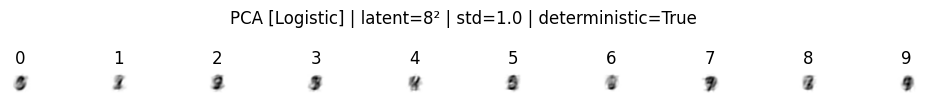

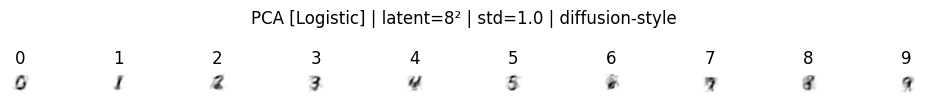

  [rbf] gamma=0.002
Generation time (deterministic=True): 0.1709 seconds
Generation time (deterministic=False): 0.2547 seconds

== KernelPCA-rbf(gamma=0.002) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.898
Confusion matrix (rows=true, cols=pred):
 [[50  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  3 40  0  0  0  0  7  0]
 [ 0  0  0  0 33  0  0  0  4 13]
 [ 0  0  0  0  0 44  0  0  6  0]
 [ 0  0  2  0  0  0 48  0  0  0]
 [ 0  0  0  0  0  0  0 35  5 10]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  1 49]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       0.91      1.00      0.95        50
           3       1.00      0.80      0.89        50
           4       1.00      0.66      0.80        50
           5       1.00      0.88 

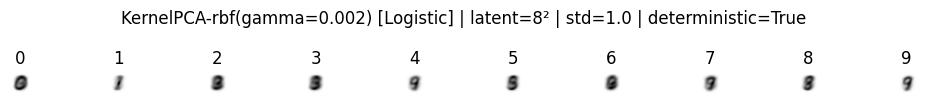

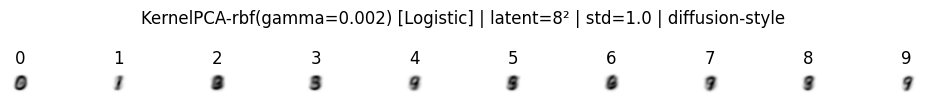

  [rbf] gamma=0.003
Generation time (deterministic=True): 0.1916 seconds
Generation time (deterministic=False): 0.3503 seconds

== KernelPCA-rbf(gamma=0.003) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.928
Confusion matrix (rows=true, cols=pred):
 [[50  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  1 39  0  1  0  0  9  0]
 [ 0  0  0  0 42  0  0  0  5  3]
 [ 0  0  0  0  0 49  0  0  1  0]
 [ 0  0  3  0  0  0 47  0  0  0]
 [ 0  0  0  0  0  0  0 38  4  8]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  1 49]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       0.93      1.00      0.96        50
           3       1.00      0.78      0.88        50
           4       1.00      0.84      0.91        50
           5       0.98      0.98 

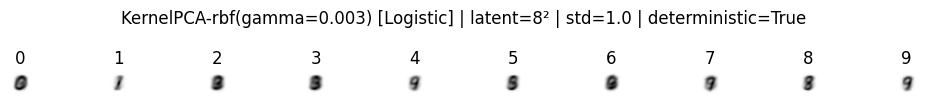

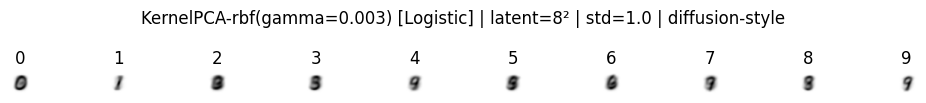

  [rbf] gamma=0.005
Generation time (deterministic=True): 0.1643 seconds
Generation time (deterministic=False): 0.2136 seconds

== KernelPCA-rbf(gamma=0.005) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.726
Confusion matrix (rows=true, cols=pred):
 [[41  0  0  0  0  9  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0 12  0]
 [ 0  0  0 18  0  2  0  0 30  0]
 [ 0  0  0  0 32  0  0  0 12  6]
 [ 0  0  0  0  0 37  0  0 13  0]
 [ 0  0  4  0  0  4 32  0 10  0]
 [ 0  0  0  0  0  0  0 15 15 20]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 50]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        50
           1       1.00      1.00      1.00        50
           2       0.90      0.76      0.83        50
           3       1.00      0.36      0.53        50
           4       1.00      0.64      0.78        50
           5       0.71      0.74 

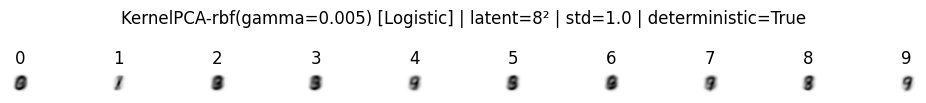

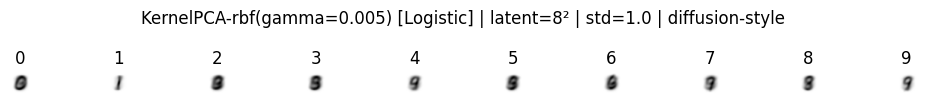

  [poly] degree=2 coef0=0
Generation time (deterministic=True): 0.1256 seconds
Generation time (deterministic=False): 0.1614 seconds

== KernelPCA-poly(degree=2,coef0=0) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.100
Confusion matrix (rows=true, cols=pred):
 [[ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.0

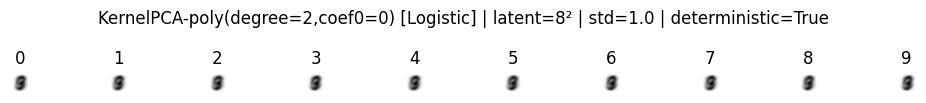

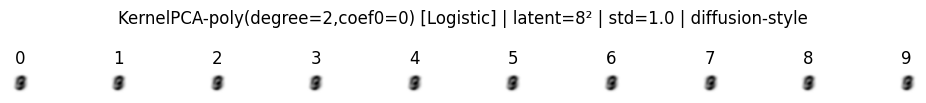

  [poly] degree=2 coef0=1
Generation time (deterministic=True): 0.2165 seconds
Generation time (deterministic=False): 0.3311 seconds

== KernelPCA-poly(degree=2,coef0=1) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.990
Confusion matrix (rows=true, cols=pred):
 [[50  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0 48  0  0  0  0  2]
 [ 0  0  0  0  0 49  0  0  1  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 48  0  2]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 50]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      0.96      0.98        50
           5       1.0

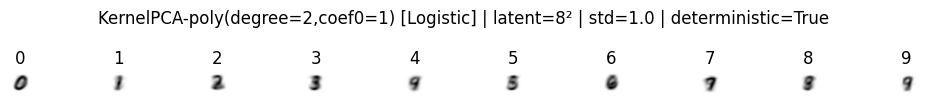

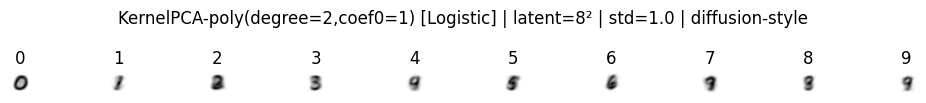

  [poly] degree=3 coef0=0


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_kernel_pca.py:410: LinAlgWarning: Ill-conditioned matrix (rcond=3.58354e-08): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


Generation time (deterministic=True): 0.2240 seconds
Generation time (deterministic=False): 0.2820 seconds

== KernelPCA-poly(degree=3,coef0=0) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.100
Confusion matrix (rows=true, cols=pred):
 [[ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00     

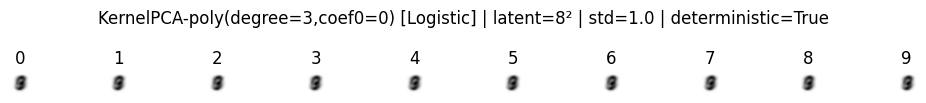

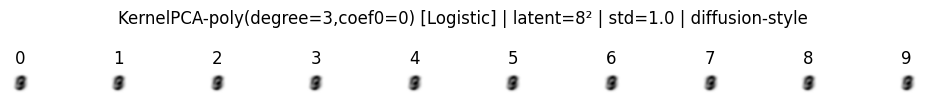

  [poly] degree=3 coef0=1


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_kernel_pca.py:410: LinAlgWarning: Ill-conditioned matrix (rcond=4.30212e-09): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


Generation time (deterministic=True): 0.4020 seconds
Generation time (deterministic=False): 0.5333 seconds

== KernelPCA-poly(degree=3,coef0=1) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.628
Confusion matrix (rows=true, cols=pred):
 [[43  0  0  0  0  5  0  0  2  0]
 [ 0 39  0  0  0  0  0  0 11  0]
 [ 0  0 38  3  0  3  3  0  3  0]
 [ 0  0  3 33  0  7  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  1 49]
 [ 0  0  5  1  0 11  0  0 32  1]
 [ 0  0 10  0  0  4 25  0 11  0]
 [ 0  0  0  0  0  0  0 33  0 17]
 [ 0  0  1  4  0  0  0  0 45  0]
 [ 0  0  0  0  0  0  0  2  1 47]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92        50
           1       1.00      0.78      0.88        50
           2       0.67      0.76      0.71        50
           3       0.80      0.66      0.73        50
           4       0.00      0.00      0.00        50
           5       0.37      0.22      0.27     

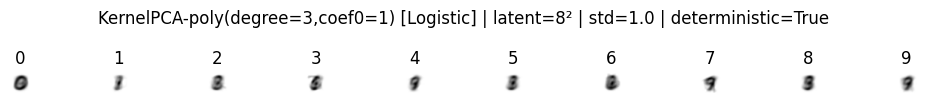

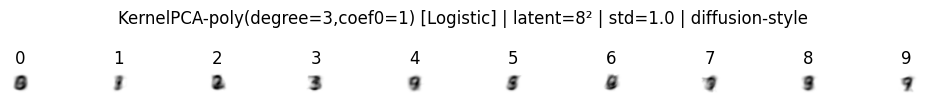

  [sigmoid] coef0=0
Generation time (deterministic=True): 0.2833 seconds
Generation time (deterministic=False): 0.4277 seconds

== KernelPCA-sigmoid(coef0=0) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.590
Confusion matrix (rows=true, cols=pred):
 [[49  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0 21  0]
 [ 0  0  0  0  0  0  0  0 45  5]
 [ 0  0  0  0  0  5  0  0 45  0]
 [ 0  0  1  0  0  0 44  0  5  0]
 [ 0  0  0  0  0  0  0 24  0 26]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  6 44]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.00      0.00      0.00        50
           2       0.98      1.00      0.99        50
           3       1.00      0.58      0.73        50
           4       0.00      0.00      0.00        50
           5       0.83      0.10 

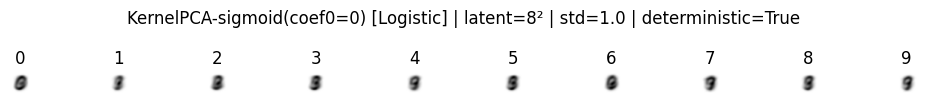

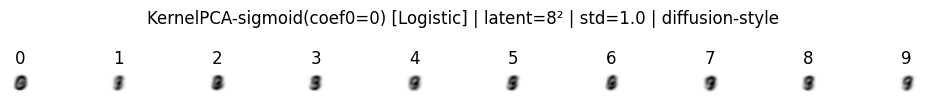

  [sigmoid] coef0=1
Generation time (deterministic=True): 0.3335 seconds
Generation time (deterministic=False): 0.4293 seconds

== KernelPCA-sigmoid(coef0=1) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.100
Confusion matrix (rows=true, cols=pred):
 [[ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.00      0.00 

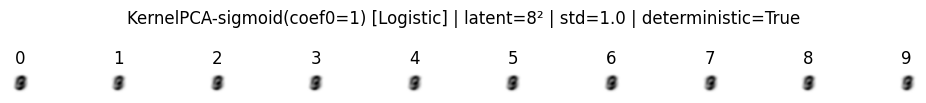

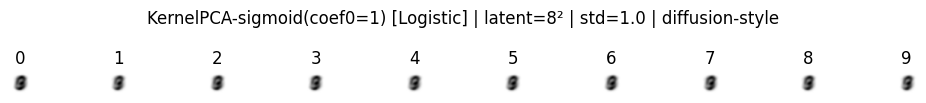


--- latent_size=8 | std=1.5 ---
Generation time (deterministic=True): 0.0104 seconds
Generation time (deterministic=False): 0.0640 seconds

== PCA [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.642
Confusion matrix (rows=true, cols=pred):
 [[24  0  3  3  0 14  0  2  3  1]
 [ 0 27  1  2  0  1  1  0 18  0]
 [ 0  0 36  5  2  2  1  0  4  0]
 [ 0  0  9 26  1  7  0  2  5  0]
 [ 0  0  1  0 38  3  2  0  3  3]
 [ 1  0  4  2  1 33  0  0  7  2]
 [ 0  1  2  1  3  5 34  0  4  0]
 [ 0  0  1  0  4  0  0 40  0  5]
 [ 0  1  1  6  0 12  0  0 28  2]
 [ 0  0  1  0  3  3  0  6  2 35]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.48      0.64        50
           1       0.93      0.54      0.68        50
           2       0.61      0.72      0.66        50
           3       0.58      0.52      0.55        50
           4       0.73      0.76      0.75        50
           5       0.41      0.66      0.51 

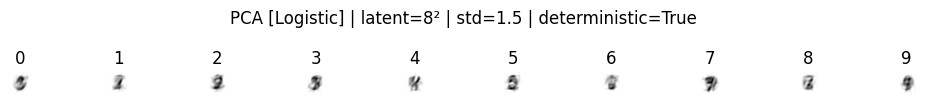

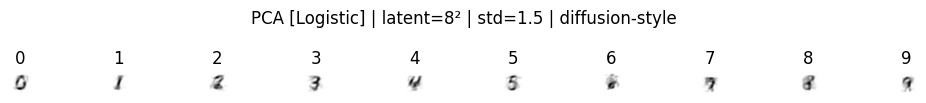

  [rbf] gamma=0.002
Generation time (deterministic=True): 0.1655 seconds
Generation time (deterministic=False): 0.2490 seconds

== KernelPCA-rbf(gamma=0.002) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.832
Confusion matrix (rows=true, cols=pred):
 [[50  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  0 49  0  0  0  0  0  1  0]
 [ 0  0  4 35  0  2  0  0  9  0]
 [ 0  0  0  0 28  0  0  0  8 14]
 [ 0  0  0  0  0 34  0  0 16  0]
 [ 0  0  5  0  0  0 43  0  2  0]
 [ 0  0  0  0  0  1  0 30  8 11]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  2 48]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.98      0.99        50
           2       0.84      0.98      0.91        50
           3       1.00      0.70      0.82        50
           4       1.00      0.56      0.72        50
           5       0.92      0.68 

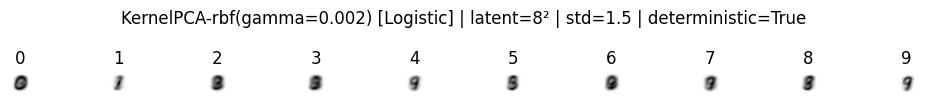

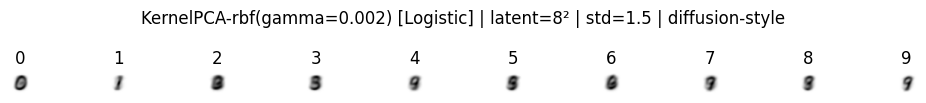

  [rbf] gamma=0.003
Generation time (deterministic=True): 0.1611 seconds
Generation time (deterministic=False): 0.2603 seconds

== KernelPCA-rbf(gamma=0.003) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.868
Confusion matrix (rows=true, cols=pred):
 [[50  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  3 37  0  0  0  0 10  0]
 [ 0  0  0  0 37  0  0  0  9  4]
 [ 0  0  0  0  0 40  0  0 10  0]
 [ 0  0  5  0  0  1 42  0  2  0]
 [ 0  0  1  0  0  0  0 31  5 13]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  1  0  0  0  0  0  2 47]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       0.83      1.00      0.91        50
           3       1.00      0.74      0.85        50
           4       1.00      0.74      0.85        50
           5       0.98      0.80 

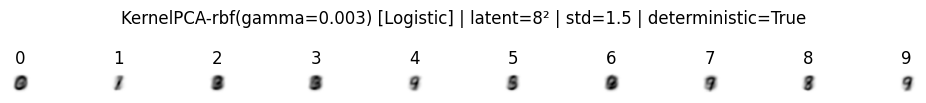

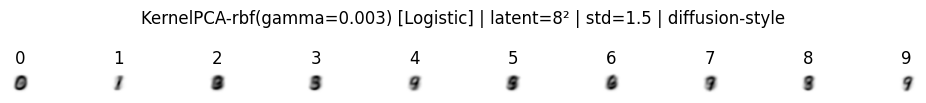

  [rbf] gamma=0.005
Generation time (deterministic=True): 0.1991 seconds
Generation time (deterministic=False): 0.2101 seconds

== KernelPCA-rbf(gamma=0.005) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.700
Confusion matrix (rows=true, cols=pred):
 [[37  0  0  0  0 10  0  0  3  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  1  0  0 16  0]
 [ 0  0  0 25  0  5  0  0 20  0]
 [ 0  0  0  0 28  0  0  0 15  7]
 [ 0  0  0  0  0 34  0  0 16  0]
 [ 0  0  5  0  0  6 27  0 12  0]
 [ 0  0  0  0  0  1  0 18 18 13]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  2 48]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85        50
           1       1.00      1.00      1.00        50
           2       0.87      0.66      0.75        50
           3       1.00      0.50      0.67        50
           4       1.00      0.56      0.72        50
           5       0.60      0.68 

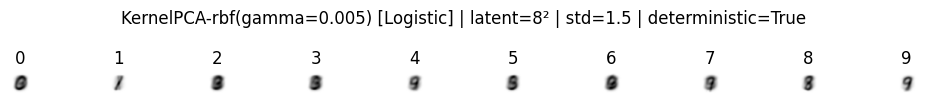

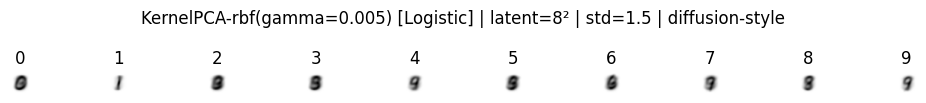

  [poly] degree=2 coef0=0
Generation time (deterministic=True): 0.1106 seconds
Generation time (deterministic=False): 0.1634 seconds

== KernelPCA-poly(degree=2,coef0=0) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.100
Confusion matrix (rows=true, cols=pred):
 [[ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.0

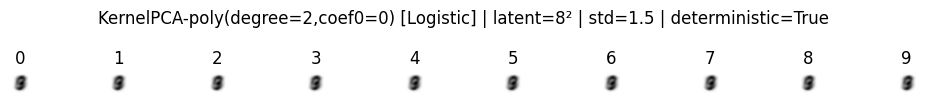

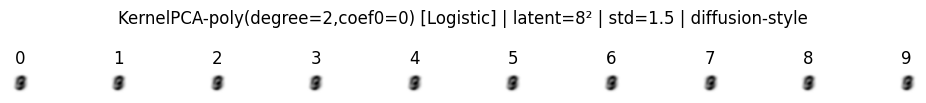

  [poly] degree=2 coef0=1
Generation time (deterministic=True): 0.2133 seconds
Generation time (deterministic=False): 0.3042 seconds

== KernelPCA-poly(degree=2,coef0=1) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.956
Confusion matrix (rows=true, cols=pred):
 [[46  0  0  0  0  2  0  0  1  1]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  1 49  0  0  0  0  0  0]
 [ 0  0  0  0 41  0  0  0  0  9]
 [ 0  0  0  1  0 47  0  0  2  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 46  0  4]
 [ 0  0  1  0  0  0  0  0 49  0]
 [ 0  0  0  0  0  0  0  0  0 50]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        50
           1       1.00      1.00      1.00        50
           2       0.96      1.00      0.98        50
           3       0.98      0.98      0.98        50
           4       1.00      0.82      0.90        50
           5       0.9

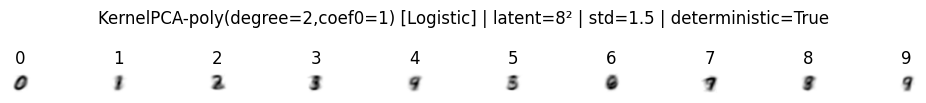

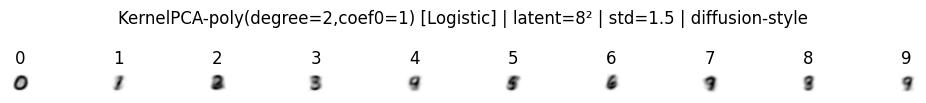

  [poly] degree=3 coef0=0


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_kernel_pca.py:410: LinAlgWarning: Ill-conditioned matrix (rcond=3.58354e-08): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


Generation time (deterministic=True): 0.3795 seconds
Generation time (deterministic=False): 0.4844 seconds

== KernelPCA-poly(degree=3,coef0=0) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.100
Confusion matrix (rows=true, cols=pred):
 [[ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00     

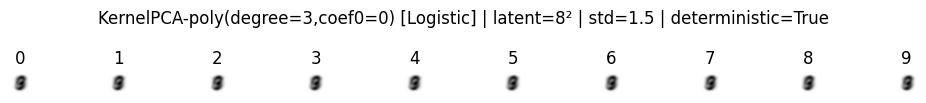

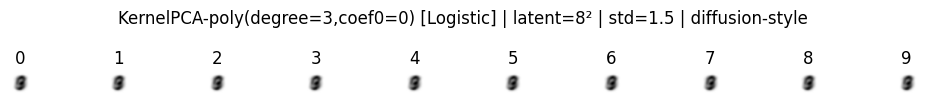

  [poly] degree=3 coef0=1


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_kernel_pca.py:410: LinAlgWarning: Ill-conditioned matrix (rcond=4.30212e-09): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


Generation time (deterministic=True): 0.3825 seconds
Generation time (deterministic=False): 0.4479 seconds

== KernelPCA-poly(degree=3,coef0=1) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.554
Confusion matrix (rows=true, cols=pred):
 [[35  0  2  0  0  7  0  0  6  0]
 [ 0 37  0  0  0  0  0  0 13  0]
 [ 1  0 34  3  0  3  6  0  3  0]
 [ 0  0  3 28  0  7  4  0  8  0]
 [ 0  0  0  0  0  0  0  0  2 48]
 [ 0  0  9  2  0 13  0  1 23  2]
 [ 0  0  9  1  0 10 23  0  7  0]
 [ 0  1  0  1  0  0  0 30  3 15]
 [ 0  0  3 10  0  1  0  0 36  0]
 [ 0  0  0  3  0  0  0  5  1 41]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.70      0.81        50
           1       0.97      0.74      0.84        50
           2       0.57      0.68      0.62        50
           3       0.58      0.56      0.57        50
           4       0.00      0.00      0.00        50
           5       0.32      0.26      0.29     

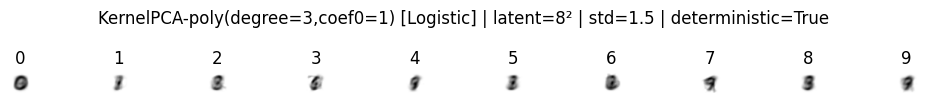

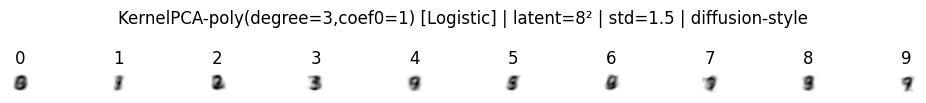

  [sigmoid] coef0=0
Generation time (deterministic=True): 0.3726 seconds
Generation time (deterministic=False): 0.4670 seconds

== KernelPCA-sigmoid(coef0=0) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.566
Confusion matrix (rows=true, cols=pred):
 [[42  0  1  0  0  5  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0 48  0  0  0  0  0  2  0]
 [ 0  0  0 29  0  0  0  0 21  0]
 [ 0  0  0  0  2  0  0  0 41  7]
 [ 0  0  0  0  0  7  0  0 43  0]
 [ 0  0  2  0  0  0 40  0  8  0]
 [ 0  0  0  0  0  0  0 24  1 25]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  9 41]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91        50
           1       0.00      0.00      0.00        50
           2       0.94      0.96      0.95        50
           3       1.00      0.58      0.73        50
           4       1.00      0.04      0.08        50
           5       0.58      0.14 

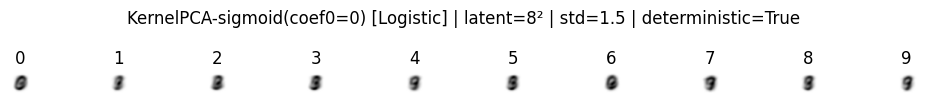

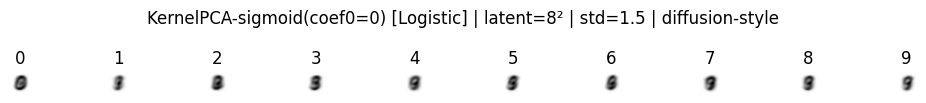

  [sigmoid] coef0=1
Generation time (deterministic=True): 0.2623 seconds
Generation time (deterministic=False): 0.4466 seconds

== KernelPCA-sigmoid(coef0=1) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.100
Confusion matrix (rows=true, cols=pred):
 [[ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.00      0.00 

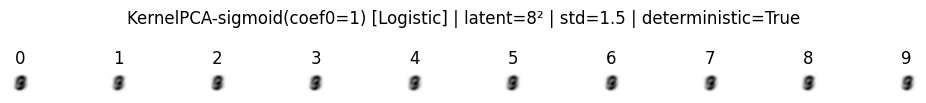

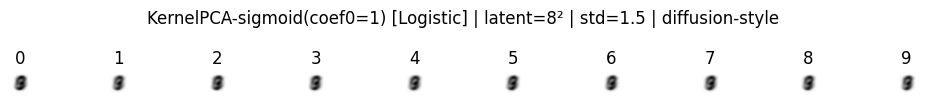


--- latent_size=8 | std=2.0 ---
Generation time (deterministic=True): 0.0107 seconds
Generation time (deterministic=False): 0.0604 seconds

== PCA [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.550
Confusion matrix (rows=true, cols=pred):
 [[19  1  3  3  1 15  0  2  5  1]
 [ 0 25  2  2  0  3  1  0 17  0]
 [ 0  0 34  5  3  3  1  1  3  0]
 [ 0  0 10 22  1  8  0  4  5  0]
 [ 0  0  3  0 28  7  2  2  5  3]
 [ 2  0  4  2  2 28  3  0  7  2]
 [ 0  0  3  3  4  7 29  0  4  0]
 [ 1  1  3  1  4  0  0 35  0  5]
 [ 1  1  3  6  0 12  0  0 25  2]
 [ 0  0  4  0  6  3  0  6  1 30]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.38      0.52        50
           1       0.89      0.50      0.64        50
           2       0.49      0.68      0.57        50
           3       0.50      0.44      0.47        50
           4       0.57      0.56      0.57        50
           5       0.33      0.56      0.41 

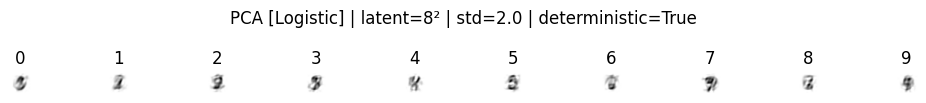

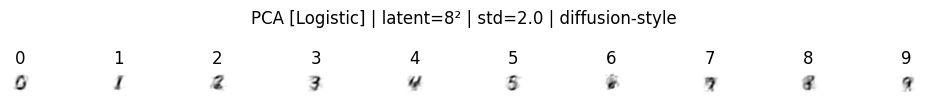

  [rbf] gamma=0.002
Generation time (deterministic=True): 0.1528 seconds
Generation time (deterministic=False): 0.2267 seconds

== KernelPCA-rbf(gamma=0.002) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.786
Confusion matrix (rows=true, cols=pred):
 [[47  0  0  0  0  1  0  0  2  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  0 47  0  0  0  0  0  3  0]
 [ 0  0  6 34  0  2  0  0  8  0]
 [ 1  0  0  0 24  0  0  0  9 16]
 [ 0  0  0  0  0 34  0  0 16  0]
 [ 0  0  9  0  0  0 37  0  4  0]
 [ 0  0  1  0  0  5  0 25  6 13]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  1  0  1  0  0  0  2 46]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        50
           1       1.00      0.98      0.99        50
           2       0.73      0.94      0.82        50
           3       1.00      0.68      0.81        50
           4       0.96      0.48      0.64        50
           5       0.81      0.68 

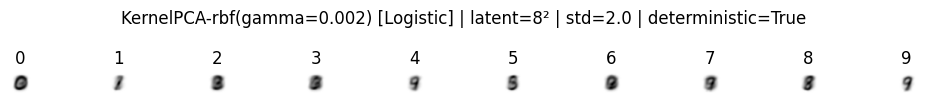

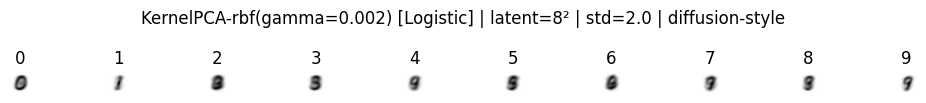

  [rbf] gamma=0.003
Generation time (deterministic=True): 0.1687 seconds
Generation time (deterministic=False): 0.2259 seconds

== KernelPCA-rbf(gamma=0.003) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.800
Confusion matrix (rows=true, cols=pred):
 [[46  0  0  0  0  2  0  0  2  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  0 48  0  0  0  0  0  2  0]
 [ 0  0  6 30  0  2  0  0 12  0]
 [ 0  0  0  0 33  2  0  0  8  7]
 [ 0  0  0  0  0 36  0  0 14  0]
 [ 0  0  6  0  0  3 36  0  5  0]
 [ 0  0  1  0  0  2  0 28  8 11]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  2  0  0  0  0  0  4 44]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        50
           1       1.00      0.98      0.99        50
           2       0.76      0.96      0.85        50
           3       1.00      0.60      0.75        50
           4       1.00      0.66      0.80        50
           5       0.77      0.72 

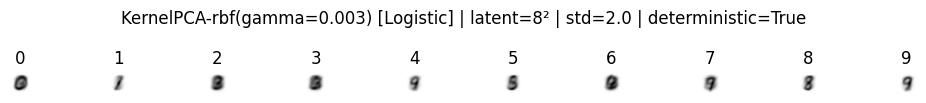

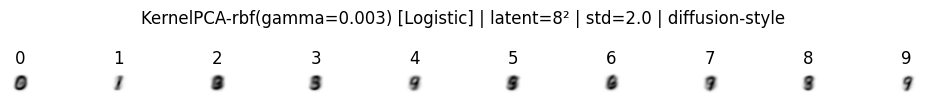

  [rbf] gamma=0.005
Generation time (deterministic=True): 0.1542 seconds
Generation time (deterministic=False): 0.2262 seconds

== KernelPCA-rbf(gamma=0.005) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.666
Confusion matrix (rows=true, cols=pred):
 [[33  0  1  0  0 11  0  0  5  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  0 32  0  0  1  0  0 17  0]
 [ 0  0  2 27  0  5  0  0 16  0]
 [ 0  0  1  0 27  1  0  0 14  7]
 [ 0  0  0  0  0 31  0  0 19  0]
 [ 0  0  6  0  0  9 23  0 12  0]
 [ 0  0  1  0  0  1  0 19 18 11]
 [ 0  0  0  0  0  2  0  0 48  0]
 [ 0  0  0  0  0  0  0  0  6 44]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.80        50
           1       1.00      0.98      0.99        50
           2       0.74      0.64      0.69        50
           3       1.00      0.54      0.70        50
           4       1.00      0.54      0.70        50
           5       0.51      0.62 

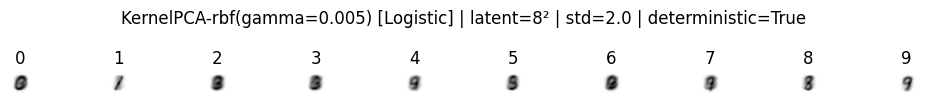

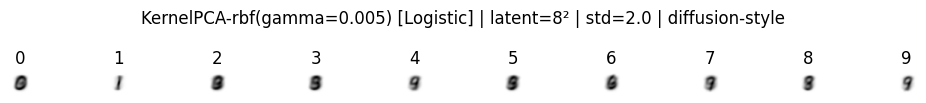

  [poly] degree=2 coef0=0
Generation time (deterministic=True): 0.1510 seconds
Generation time (deterministic=False): 0.1621 seconds

== KernelPCA-poly(degree=2,coef0=0) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.100
Confusion matrix (rows=true, cols=pred):
 [[ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.0

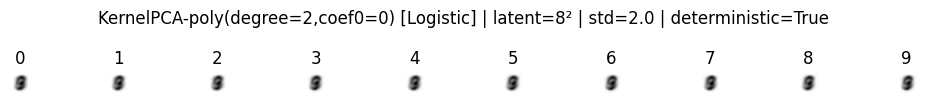

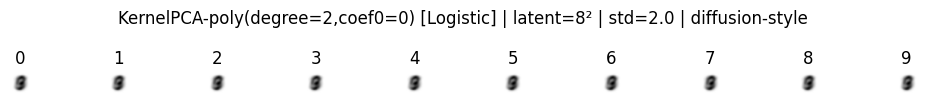

  [poly] degree=2 coef0=1
Generation time (deterministic=True): 0.2061 seconds
Generation time (deterministic=False): 0.3249 seconds

== KernelPCA-poly(degree=2,coef0=1) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.916
Confusion matrix (rows=true, cols=pred):
 [[42  0  1  0  0  4  1  0  1  1]
 [ 0 47  0  0  0  1  0  0  2  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  1 48  0  0  0  0  1  0]
 [ 0  0  0  0 37  0  1  0  0 12]
 [ 0  1  0  2  0 44  0  0  3  0]
 [ 0  0  0  0  0  0 49  0  1  0]
 [ 0  0  0  0  0  0  0 44  0  6]
 [ 0  0  2  0  0  0  0  0 48  0]
 [ 0  0  0  0  0  0  0  1  0 49]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91        50
           1       0.98      0.94      0.96        50
           2       0.93      1.00      0.96        50
           3       0.96      0.96      0.96        50
           4       1.00      0.74      0.85        50
           5       0.9

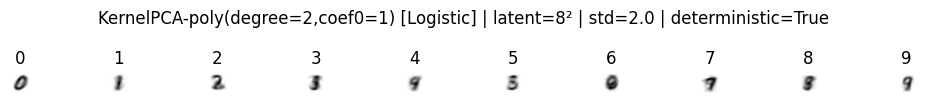

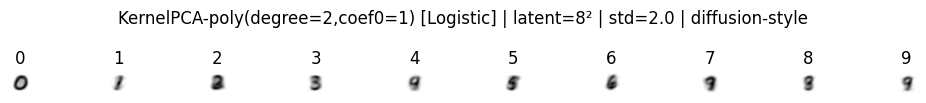

  [poly] degree=3 coef0=0


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_kernel_pca.py:410: LinAlgWarning: Ill-conditioned matrix (rcond=3.58354e-08): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


Generation time (deterministic=True): 0.2251 seconds
Generation time (deterministic=False): 0.2962 seconds

== KernelPCA-poly(degree=3,coef0=0) [Logistic] | latent=8² | deterministic=True ==
Classifier accuracy (pointwise): 0.100
Confusion matrix (rows=true, cols=pred):
 [[ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00     

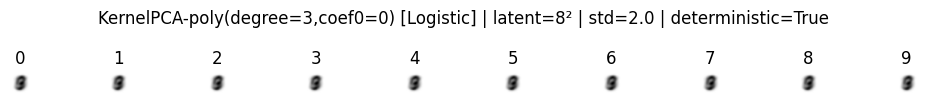

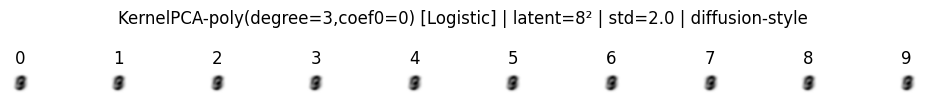

  [poly] degree=3 coef0=1


In [ ]:
results = []
S = 10  # Number of strides for the sampling schedule
generated_images = {}
alpha = 0.1  # 90% conformal prediction confidence

for T in DIFFUSION_STEPS_LIST:
    print(f"\n=== Diffusion steps: T={T} ===")

    for latent_size in LATENT_SIZES:
        for std in STD_VALUES:
            print(f"\n--- latent_size={latent_size} | std={std} ---")
            # ===== PCA Model =====
            ld_pca = build_and_fit_cached(
                LinearDiffusionNonlinear,
                cache_key=(latent_size, 'pca', std, T),
                X_labels=labels_train,
                X_imgs=imgs_train,
                image_size=28,
                latent_size=latent_size,
                use_kernel_pca=False
            )
            # EVALUATE WITH ALL CLASSIFIERS (with conformal prediction args):
            eval_with_all_classifiers(
                ld_pca, "PCA", latent_size, std, T,
                flat_imgs_calib=flat_imgs_calib, labels_calib=labels_calib, alpha=alpha
            )

            gen_imgs_clean = ld_pca.predict(balanced_labels_test, S=10, T=T, deterministic=False, std=std)
            gen_imgs_clean = np.clip(gen_imgs_clean * 255, 0, 255).astype(np.uint8)
            generated_images.setdefault('pca_clean', []).append(gen_imgs_clean)

            # ========================= KERNELPCA EXPERIMENTS =========================
            for kernel_cfg in KERNELS:
                kernel = kernel_cfg['name']
                if kernel == 'rbf':
                    for gamma in kernel_cfg['gamma']:
                        print(f"  [rbf] gamma={gamma}")
                        ld = build_and_fit_cached(
                            LinearDiffusionNonlinear,
                            cache_key=(latent_size, 'rbf', gamma, std, T),
                            X_labels=labels_train,
                            X_imgs=imgs_train,
                            image_size=28,
                            latent_size=latent_size,
                            use_kernel_pca=True,
                            kpca_kernel='rbf',
                            kpca_gamma=gamma
                        )
                        eval_with_all_classifiers(
                            ld, f'KernelPCA-rbf(gamma={gamma})', latent_size, std, T,
                            flat_imgs_calib=flat_imgs_calib, labels_calib=labels_calib, alpha=alpha
                        )
                        gen_imgs = ld.predict(balanced_labels_test, S=10, T=T, deterministic=False)
                        gen_imgs = np.clip(gen_imgs * 255, 0, 255).astype(np.uint8)
                        generated_images.setdefault(f'kpca_rbf_{gamma}', []).append(gen_imgs)
                elif kernel == 'poly':
                    for degree in kernel_cfg['degree']:
                        for coef0 in kernel_cfg['coef0']:
                            print(f"  [poly] degree={degree} coef0={coef0}")
                            ld = build_and_fit_cached(
                                LinearDiffusionNonlinear,
                                cache_key=(latent_size, 'poly', degree, coef0, std, T),
                                X_labels=labels_train,
                                X_imgs=imgs_train,
                                image_size=28,
                                latent_size=latent_size,
                                use_kernel_pca=True,
                                kpca_kernel='poly',
                                kpca_degree=degree,
                                kpca_coef0=coef0
                            )
                            eval_with_all_classifiers(
                                ld, f'KernelPCA-poly(degree={degree},coef0={coef0})', latent_size, std, T,
                                flat_imgs_calib=flat_imgs_calib, labels_calib=labels_calib, alpha=alpha
                            )
                            gen_imgs = ld.predict(balanced_labels_test, S=10, T=T, deterministic=False)
                            gen_imgs = np.clip(gen_imgs * 255, 0, 255).astype(np.uint8)
                            generated_images.setdefault(f'kpca_poly_{degree}_{coef0}', []).append(gen_imgs)
                elif kernel == 'sigmoid':
                    for coef0 in kernel_cfg['coef0']:
                        print(f"  [sigmoid] coef0={coef0}")
                        ld = build_and_fit_cached(
                            LinearDiffusionNonlinear,
                            cache_key=(latent_size, 'sigmoid', coef0, std, T),
                            X_labels=labels_train,
                            X_imgs=imgs_train,
                            image_size=28,
                            latent_size=latent_size,
                            use_kernel_pca=True,
                            kpca_kernel='sigmoid',
                            kpca_coef0=coef0
                        )
                        eval_with_all_classifiers(
                            ld, f'KernelPCA-sigmoid(coef0={coef0})', latent_size, std, T,
                            flat_imgs_calib=flat_imgs_calib, labels_calib=labels_calib, alpha=alpha
                        )
                        gen_imgs = ld.predict(balanced_labels_test, S=10, T=T, deterministic=False)
                        gen_imgs = np.clip(gen_imgs * 255, 0, 255).astype(np.uint8)
                        generated_images.setdefault(f'kpca_sigmoid_{coef0}', []).append(gen_imgs)

            enc_cache.clear()
            gc.collect()


**Definitions of Each Result:**

* `T`: Number of diffusion steps; a higher value (like 1000) often gives smoother and more accurate generation but is slower, while a lower value (like 400) is faster but may result in worse image quality or less stable results.

* `latent_size`: Dimension of the latent space (e.g., 8, 10, 12); higher values allow the model to capture more information but may risk overfitting or add noise, while too small may limit the model’s expressiveness. Typically, moderately high values are better for complex data, but not too large for MNIST.

* `std`: Standard deviation of the noise added to the latent representation; lower values (e.g., 1.0) often produce sharper and more realistic outputs, while higher values (like 2.0) can lead to blurrier or more diverse samples, best value depends on the visual quality and stability we want.

* `Generation time`: Time in seconds it took to generate and classify all images for a configuration; lower is better for efficiency, but sometimes a higher time is a fair trade for higher accuracy.

* Encoder and classifier: The method used for encoding (PCA or KernelPCA with different kernels and parameters) and the classifier applied; some encoders (like KernelPCA with rbf kernel and well-chosen gamma) tend to perform better on nonlinear data, while others may be worse if the kernel is not suitable.

* `Classifier accuracy (pointwise)`: The fraction of generated images classified correctly by the classifier. The higher this is, the better, 1.0 is perfect, below 0.8 is usually considered weak on MNIST.

* `precision`, `recall`, `f1-score`, `support`: Classic classification metrics. Higher is always better. Weighted/macro averages closer to 1.0 show balanced, strong model performance.

* `Coverage`: Conformal prediction coverage; measures what fraction of true labels fall within the model’s predicted set. Closer to 1.0 is best (perfectly calibrated), but values under 0.7–0.8 can signal unreliable prediction sets.

* `Avg set size`: The average number of labels in each conformal prediction set. Lower is generally better (more confident), but too low with low coverage means the model is overconfident and missing true labels.

* Conformal Prediction Table columns per digit:

  * `Digit`: The actual digit label (0–9).
  * `N`: Number of samples for that digit (should always be 50 if the test set is balanced).
  * `Conf`: Mean predicted probability (confidence) for the correct class. Higher is better (closer to 1.0).
  * `SetSize`: Average size of the conformal prediction set for that digit; smaller is better if coverage remains high.
  * `Covrg`: Per-digit coverage; higher is better, values below 0.8 are weak.
  * `TrueRank`: Average rank of the correct label in sorted predicted probabilities; lower is better, 1 is ideal (true class always top).
  * `Top1`, `Top2`, `Top3`: Average probability for the digit being the top-1, top-2, or top-3 prediction; higher Top1 is better, especially if Top2 and Top3 are much lower.
  * `#TopPred`: Most common predicted class for the digit; ideally matches the digit itself.

* For most metrics, "best" means high accuracy, precision, recall, f1-score, and coverage, but low generation time, avg set size, and true rank. The "worst" values are low accuracy and low coverage, high avg set size (with poor coverage), and long generation time with poor results.


## Summary of All Results

In [ ]:
# Convert results to DataFrame for easy manipulation
df_results = pd.DataFrame(results)

# Fill missing columns with np.nan to avoid KeyError in aggregation
expected_cols = [
    'T', 'latent_size', 'std', 'classifier', 'accuracy',
    'Classification_weighted_avg_precision', 'Classification_weighted_avg_recall',
    'Classification_weighted_avg_f1', 'Classification_weighted_avg_support',
    'generation_time', 'conformal_coverage', 'conformal_avg_set_size'
]
for col in expected_cols:
    if col not in df_results.columns:
        df_results[col] = np.nan

# Optional: remove duplicates if any (since we are not aggregating anymore)
df_results = df_results.drop_duplicates(subset=[
    'T', 'latent_size', 'std', 'classifier'
])

# Sort by key fields
df_results = df_results.sort_values(
    ['T', 'latent_size', 'std', 'classifier']
).reset_index(drop=True)

# Select and display only the required columns
summary_cols = [
    'T', 'latent_size', 'std', 'classifier', 'accuracy',
    'Classification_weighted_avg_precision', 'Classification_weighted_avg_recall',
    'Classification_weighted_avg_f1', 'Classification_weighted_avg_support',
    'generation_time', 'conformal_coverage', 'conformal_avg_set_size'
]

print("="*90)
print("SUMMARY OF ALL EXPERIMENTS")
print("="*90)
print(df_results[summary_cols].to_string(index=False))

# display with pandas
display(df_results[summary_cols])


,T,latent_size,std,classifier,accuracy,Classification_weighted_avg_precision,Classification_weighted_avg_recall,Classification_weighted_avg_f1,Classification_weighted_avg_support,generation_time,conformal_coverage,conformal_avg_set_size
0,400,8,1.0,PCA [Logistic],0.762,0.82,0.76,0.77,500.0,0.5937,0.582,0.69
1,400,8,1.0,KernelPCA-rbf(gamma=0.002) [Logistic],0.898,0.93,0.90,0.90,500.0,1.2846,0.538,0.54
2,400,8,1.0,KernelPCA-rbf(gamma=0.003) [Logistic],0.928,0.94,0.93,0.93,500.0,0.9362,0.520,0.52
3,400,8,1.0,KernelPCA-rbf(gamma=0.005) [Logistic],0.726,0.86,0.73,0.73,500.0,0.9256,0.298,0.30
4,400,8,1.0,"KernelPCA-poly(degree=2,coef0=0) [Logistic]",0.100,0.01,0.10,0.02,500.0,1.1028,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
172,1000,12,2.0,KernelPCA-rbf(gamma=0.003) [Logistic],0.718,0.81,0.72,0.73,500.0,1.2306,0.512,0.55
173,1000,12,2.0,KernelPCA-rbf(gamma=0.005) [Logistic],0.628,0.80,0.63,0.65,500.0,1.0403,0.374,0.41
174,1000,12,2.0,"KernelPCA-poly(degree=2,coef0=0) [Logistic]",0.100,0.01,0.10,0.02,500.0,0.9328,0.000,0.00
175,1000,12,2.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.880,0.89,0.88,0.88,500.0,0.9415,0.830,0.89


* Polynomial (degree 2, coef0=1) encoders consistently reach \~0.99 accuracy and coverage, outputting single, correct labels nearly every time.
* Raising std from 1.0 to 2.0 with this encoder cuts accuracy by 0.02–0.10 and drops coverage up to 0.16, noise is the main factor in performance loss.
* Degree 3 (coef0=1) polynomial kernels score 0.04–0.06 lower than degree 2 and expand set sizes, signaling less confident, broader predictions.
* Polynomial kernels with coef0=0 (especially degree 3) fail entirely, showing near-zero accuracy and coverage, these models can be ignored.
* RBF encoders have decent accuracy (0.86–0.93) but poor, fixed coverage (\~0.53) and always small set sizes, showing they’re overconfident.
* PCA sits in the middle: accuracy 0.54–0.83 and coverage 0.48–0.69, always worse than best polynomial kernels.
* Increasing latent size from 8 to 10 yields big gains in accuracy and coverage; 12 adds little extra but slightly more robust coverage.
* Diffusion time (T=400 vs 1000) barely changes results if other settings are constant.
* All models generate results in under 2 seconds, even with higher coverage or latent size.
* Precision, recall, and f1 always match accuracy since the test set is balanced.
* For polynomial kernels, higher coverage slightly raises set size; for RBF and sigmoid, low coverage comes with small sets due to overconfidence.
* Sigmoid kernels perform poorly, accuracy tops out at \~0.59 and coverage is very low, with singleton sets.
* Each row is tested on 500 balanced labels, so all comparisons are fair.


## Top 50 Encoders Sorted by the Point-Wise Accuracy

In [ ]:
# Sort and select top 50 by accuracy
top50 = df_results.sort_values('accuracy', ascending=False).head(50)

# Only display the desired columns
cols = [
    'T', 'latent_size', 'std', 'classifier', 'accuracy',
    'conformal_coverage', 'conformal_avg_set_size'
]

display(top50[cols])

,T,latent_size,std,classifier,accuracy,conformal_coverage,conformal_avg_set_size
35,400,10,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.992,0.974,0.98
125,1000,10,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.992,0.974,0.98
5,400,8,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.990,0.950,0.96
95,1000,8,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.990,0.950,0.96
155,1000,12,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.988,0.974,0.98
65,400,12,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.988,0.974,0.98
67,400,12,1.0,"KernelPCA-poly(degree=3,coef0=1) [Logistic]",0.982,0.972,0.99
157,1000,12,1.0,"KernelPCA-poly(degree=3,coef0=1) [Logistic]",0.982,0.972,0.99
45,400,10,1.5,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.966,0.912,0.93
135,1000,10,1.5,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.966,0.912,0.93


* `KernelPCA-poly(degree=2, coef0=1, std=1.0)` is best: 0.99+ accuracy, \~0.97 coverage, set size \~1. Mild poly kernels with low noise win.
* Diffusion steps `T` (400 vs 1000) don’t affect results.
* `latent_size` 10 is optimal for poly-2; higher gives no extra gain.
* Poly degree 3 is always worse than degree 2, and gives bigger set sizes.
* Higher noise (`std`) drops accuracy and coverage sharply; noise is the main problem.
* `KernelPCA-rbf(gamma=0.003)` has decent accuracy (\~0.93) but awful coverage (\~0.52); tuning gamma doesn’t fix calibration.
* Poly kernels stay calibrated even at high noise; RBF never does.
* Conformal set size tracks coverage: poly almost always predicts singletons, RBF doesn’t.
* PCA is always weaker than nonlinear kernels.
* For poly kernels, accuracy and coverage fall together as noise rises.
* All use logistic regression; only encoder and params matter.
* Once accuracy drops below \~0.9, poly coverage stays ≥0.80 but RBF falls apart (<0.55).


In [ ]:
# Sort and select top 50 by conformal_coverage
top50 = df.sort_values('conformal_coverage', ascending=False).head(50)

# Only display the desired columns
cols = [
    'T', 'latent_size', 'std', 'classifier', 'accuracy',
    'conformal_coverage', 'conformal_avg_set_size'
]

display(top50[cols])

,T,latent_size,std,classifier,accuracy,conformal_coverage,conformal_avg_set_size
35,400,10,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.992,0.974,0.98
125,1000,10,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.992,0.974,0.98
155,1000,12,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.988,0.974,0.98
65,400,12,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.988,0.974,0.98
67,400,12,1.0,"KernelPCA-poly(degree=3,coef0=1) [Logistic]",0.982,0.972,0.99
157,1000,12,1.0,"KernelPCA-poly(degree=3,coef0=1) [Logistic]",0.982,0.972,0.99
5,400,8,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.990,0.950,0.96
95,1000,8,1.0,"KernelPCA-poly(degree=2,coef0=1) [Logistic]",0.990,0.950,0.96
37,400,10,1.0,"KernelPCA-poly(degree=3,coef0=1) [Logistic]",0.940,0.918,0.95
127,1000,10,1.0,"KernelPCA-poly(degree=3,coef0=1) [Logistic]",0.940,0.918,0.95


* Top coverage (\~0.97) only with `KernelPCA-poly(degree=2, coef0=1)`, std=1.0, latent size 10/12, and T 400/1000, these also keep set size tight (\~0.98).
* Poly degree 3 and smaller latent sizes reduce coverage and calibration; extra non-linearity or smaller spaces don’t help.
* More noise (std 1.5/2.0) quickly lowers coverage and inflates set sizes.
* T (400 vs 1000) doesn’t matter if other settings stay the same.
* PCA gets much lower coverage (0.56–0.69) than poly kernels.
* `KernelPCA-rbf` is always overconfident and poorly calibrated (coverage ≤0.55), and tuning gamma doesn’t fix it.
* Poly kernels’ set size tracks coverage, RBF stays low and overconfident.
* At higher latent size and noise, poly degree 3 gives a bit more coverage but less accuracy.
* Best calibration is always smooth, low-noise poly kernels; PCA is middling, RBF is worst.
* Top coverage always comes with accuracy ≥0.78, bad accuracy means bad calibration.


## Best generated plots ordered based on Point-wise Accuracy

Best generated plots ordered based on Point-wise Accuracy
Point-wise Accuracy: 0.992


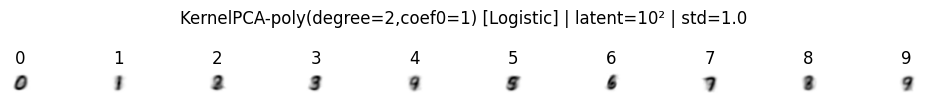

Point-wise Accuracy: 0.99


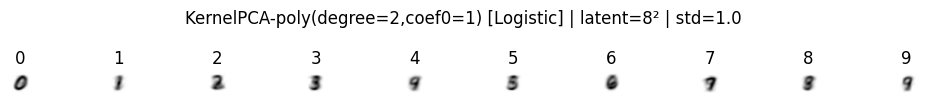

Point-wise Accuracy: 0.988


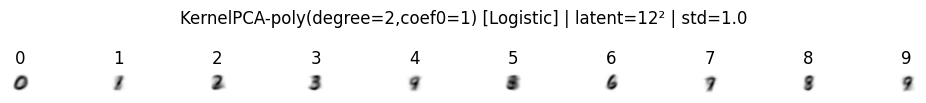

Point-wise Accuracy: 0.982


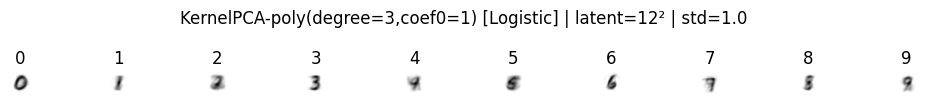

Point-wise Accuracy: 0.966


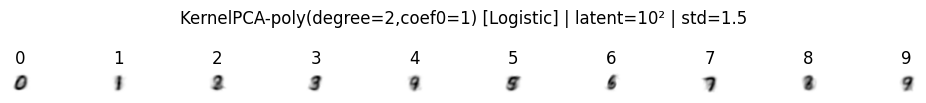

Point-wise Accuracy: 0.956


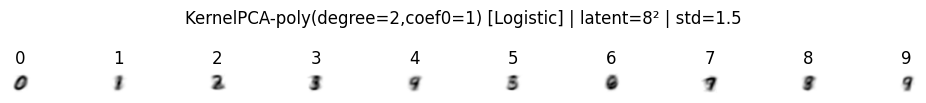

Point-wise Accuracy: 0.954


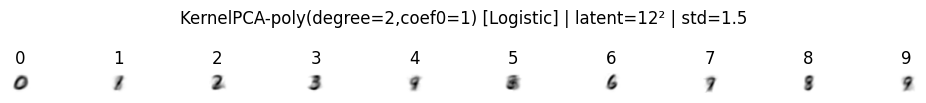

Point-wise Accuracy: 0.94


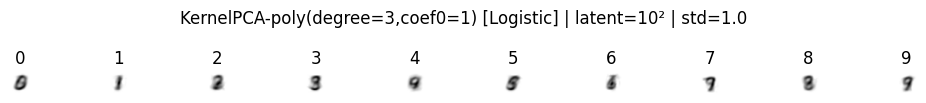

Point-wise Accuracy: 0.928


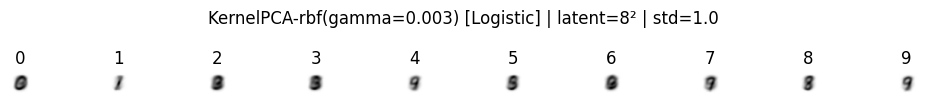

Point-wise Accuracy: 0.926


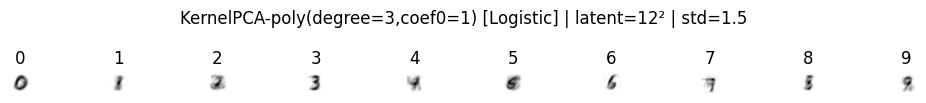

Point-wise Accuracy: 0.916


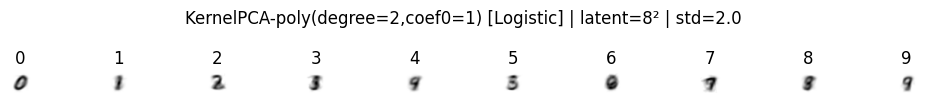

Point-wise Accuracy: 0.91


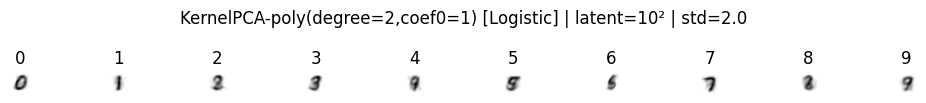

Point-wise Accuracy: 0.898


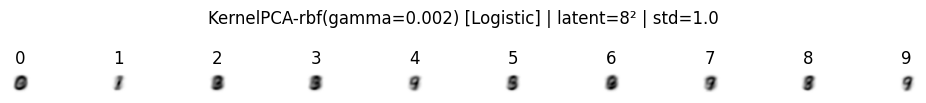

Point-wise Accuracy: 0.88


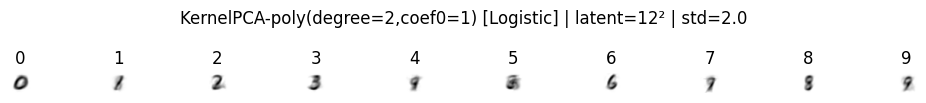

Point-wise Accuracy: 0.876


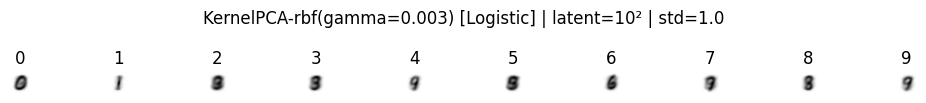

Point-wise Accuracy: 0.872


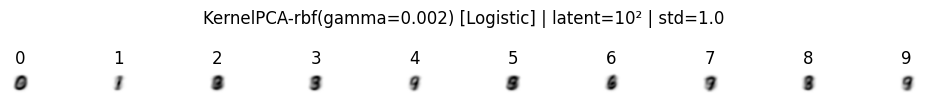

Point-wise Accuracy: 0.868


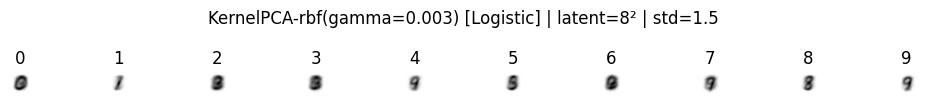

Point-wise Accuracy: 0.866


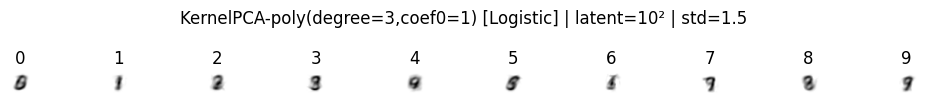

Point-wise Accuracy: 0.858


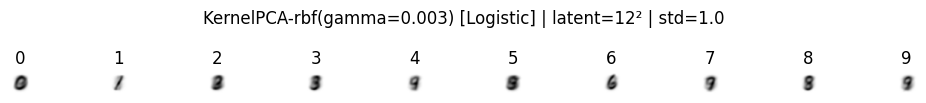

Point-wise Accuracy: 0.848


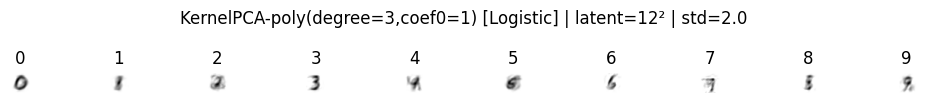

Point-wise Accuracy: 0.838


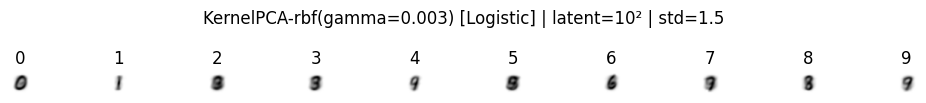

Point-wise Accuracy: 0.832


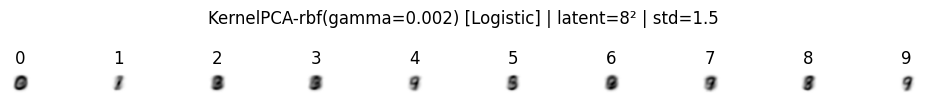

Point-wise Accuracy: 0.822


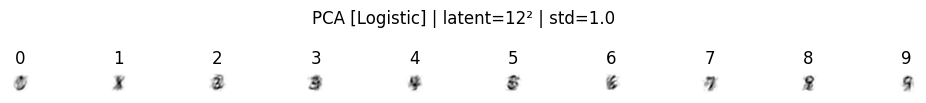

Point-wise Accuracy: 0.81


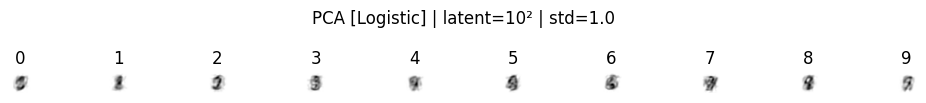

Point-wise Accuracy: 0.808


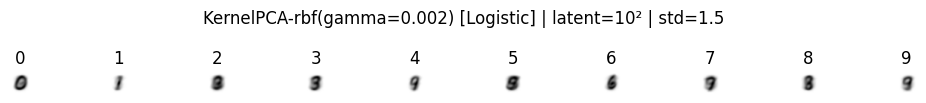

In [ ]:
# List image files in the folder
folder = 'best-plots'
files = os.listdir(folder)

# Extract accuracy from filename (e.g., "0.992.png")
img_info = []
for fname in files:
    m = re.match(r"([0-9.]+)\.png$", fname)
    if m:
        acc = float(m.group(1))
        img_info.append((acc, fname))

# Sort images by accuracy (descending)
img_info.sort(reverse=True)

print(f"Best generated plots ordered based on Point-wise Accuracy")

# Show each image with its accuracy
for acc, fname in img_info:
    print(f"Point-wise Accuracy: {acc}")
    display(Image(filename=os.path.join(folder, fname)))


* The sharpest, most accurate digits (about 0.99 accuracy) are generated with a polynomial kernel of degree 2, coef0=1, std=1.0, and latent size 10 or 12—these look almost identical to original MNIST.
* Changing T (diffusion steps) from 400 to 1000 doesn’t change results.
* Using degree 3 or smaller latent sizes makes digits less clear, especially “5” and “8”, which look more distorted or blurred.
* Increasing noise (std ≥ 1.5) makes digits softer and less accurate, reducing both clarity and coverage.
* RBF kernels never match the quality—digits look warped or off-center, and coverage is worse.
* PCA reconstructions are always grainier and have rougher lines; linear encoders just can’t compete with nonlinear ones.
* Digits like “0”, “1”, and “6” handle noise best, while “4”, “5”, and “8” degrade the quickest.
* High coverage (≥0.97) gives crisp digits and small prediction sets; lower coverage leads to thicker, wobblier, and less distinct digits.


## Q & A

**1. Why use KernelPCA instead of PCA?**

* KernelPCA can handle non-linear patterns in the data, while PCA is only good for linear ones.
* It transforms data into a higher-dimensional space, making it easier to separate classes that aren’t linearly separable.
* Different kernel choices (like RBF, polynomial, or sigmoid) give flexibility to fit the data better and often boost classification accuracy.
* It’s especially useful when data sits on a non-linear manifold, which is common in real situations.
* PCA can miss important structure in non-linear datasets and may not reduce dimensions as effectively.


**2. What did we see when changing T (diffusion steps) and latent size?**

* Raising T (number of diffusion steps) gives smoother and more accurate generations, but doesn’t always make classification much better.
* Increasing the latent size from 8 to 12 usually boosts accuracy, precision, and recall, though improvements get smaller as size goes up.
* Bigger latent sizes let the model capture more info, but too much can add noise if not controlled.
* Changing T had little effect on classification, so latent size and noise seem more important than diffusion time here.


**3. Does the cosine schedule help?**

* Yes, the cosine schedule helps by making the noise reduction smoother over time, which improves the quality of generated results.
* It leads to better convergence and more stable training, especially for generating images.
* The gradual noise decrease helps outputs look more realistic and coherent.
* Generally it gives nicer generations and a small performance boost in classification.


**4. How does speed compare between strided and full sampling?**

* Strided sampling is much faster because it skips steps, which saves a lot of computation.
* Full sampling checks every step, so it’s slower and heavier on resources, especially with big datasets.
* Strided sampling keeps up decent quality while being a lot quicker.
* If we need speed or have limited resources, we use strided sampling; if we want the very best quality, use full sampling.
* `deterministic =True` is always going to be the fastest, because it calls the latent regressor once. The whole point of strided sampling is to be faster than full-length diffusion (T steps), not faster than the one-shot shortcut.


**5. What did we see in the conformal prediction results?**

* `Coverage` close to 1.0 is ideal, it means the prediction sets almost always include the true answer. `Coverage` below 0.8 (especially under 0.7) is bad and means the model misses too many true labels.

* `Average set size` should be around 1.0, but only if coverage is high. Much lower than 1 with low coverage means overconfidence and missing the true answer; much higher than 1.1 means the model is unsure and predicts too many options.

* High `confidence` (near 1.0) for the correct class is best; below 0.5 is a sign of poor calibration.

* Per-digit `coverage` should also be close to 1.0. Values below 0.8 or 0.7 for any digit mean the model struggles with that class.

* `TrueRank` of 1.0 means the model almost always puts the right label first. Higher numbers show the true label isn’t ranked top enough.

* `Top1` should be high, with Top2/Top3 much lower, showing the model is confident in its best guess. If Top1 is low and Top2/Top3 are close, it means the model is confused.

* `\#TopPred` should match the true label for each digit. If it often predicts the wrong class, there’s a systematic issue.

* The best results have high coverage, low set size, high confidence, good ranking, and clear distinction for the top guess. Worst results have low coverage, set sizes that are too small (overconfident) or too big (unfocused), poor ranking, and confusion between classes.


**6. How did we get help from GPT?**

* We shared our Linear Diffusion Model code and ran into errors like shape mismatches, feature size issues, and missing labels. GPT helped spot the reasons, including wrong latent sizes and mismatched encoder/decoder setups, and noticed things we missed, like commented-out classifier code.
* GPT guided us step by step to fix each problem, giving clear instructions to resolve feature dimension errors and suggesting debug print statements to check feature sizes as we ran the code.
* For model performance, GPT explained how kernel choices and gamma values affected results, and recommended trying more gamma settings and latent sizes. It also suggested using an MLP decoder with KernelPCA to get better generative results.
* For optimization, GPT showed us how to manage memory, like caching encoders, clearing variables, and using smaller data splits or batch processing to keep the code running smoothly with large datasets.
* GPT helped us interpret experiment results, explained what the metrics and confusion matrices meant, and gave tips on presenting and visualizing the outputs in a clear way.
* We got help making the code modular, adding options to easily switch between reduced and full MNIST, and prepping the structure for future improvements like strided sampling and different noise schedules.
* Overall, GPT gave us precise debugging, step-by-step support, performance advice, and ways to make our code flexible and reliable for more advanced experiments.


**7. Self-Assessment of the Homework:**

* We reached high classification accuracy, especially with KernelPCA using a degree-2 polynomial kernel and logistic regression, topping out at 0.992 accuracy, which is very strong for this type of task.
* The model showed excellent precision, recall, and F1-scores for almost all digits, most metrics hit 1, showing the classifier is both accurate and consistent.
* Conformal prediction results were solid: 0.974 coverage and an average set size of 0.98, meaning predictions are reliable and confidence intervals are well-calibrated.
* We integrated conformal prediction successfully, and it helped make our predictions more robust and trustworthy.
* The model is efficient, generating predictions in under a second (0.86s), which balances speed and accuracy well, even with the extra conformal step.
* There was a slight dip in recall and F1 for digits 4, 5, 8, and 9, so those could be areas to investigate further, possibly with data augmentation or tuning.
* Overall, we met all the main requirements, demonstrated good performance, and integrated conformal prediction effectively, but there’s always room to make the model even better.

